# **Исследовательский анализ ДТП по регионам РФ**

В нашем распоряжении имеются датасеты о ДТП по 85 субъектам РФ. Данные представлены на сайте https://dtp-stat.ru/opendata и содержат информацию с января 2015- февраль 2024 (на момент проведения исследования).

**Цель проекта** - провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

Сформулированы следующие гипотезы, для их дальнейшей проверки:

*   Всему виной пьяные водители, надо усилить наказание
*   Если пешеходы не будут нарушать, то не будут гибнуть
*   Низкая скорость не влияет на тяжесть ДТП
*   Влияние стажа, только новички попадают в ДТП
*   Ужесточение наказаний в РФ влияет на количество аварий
*   Ремни безопасности не спасают во время ДТП


Перед проведением проверок гипотез необходимо выполнить предобработку данных.
Так как в данных присутствует информация о 85 регионах России, единовременная загрузка всех датасетов и их дальнейшая предобработка весьма требовательная к мощностям ПК.

Было принято решение о выгрузке случайного датасета, для ознакомления с данными, удалении избыточной информации, преобразовании типов данных для экономии памяти ПК.

По результату должны быть созданы функции, которые позволят выгрузить, преобработать и объединить данные в один датасет для дальнейшего анализа.

По данным сайта о ДТП, структура загружаемых файлов имеет следующий вид:


    "id": 384094, # идентификатор
    "tags": ["Дорожно-транспортные происшествия"], # показатели с официального сайта ГИБДД
    "light": "Светлое время суток", # время суток
    "point": {"lat": 50.6039, "long": 36.5578}, # координаты
    "nearby": [ "Нерегулируемый перекрёсток неравнозначных улиц (дорог)", "Жилые дома индивидуальной застройки"], # координаты
    "region": "Белгород", # город/район
    "address": "г Белгород, ул Сумская, 30", # адрес
    "weather": ["Ясно"], # погода
    "category": "Столкновение", # тип ДТП
    "datetime": "2017-08-05 13:06:00", # дата и время
    "severity": "Легкий", # тяжесть ДТП/вред здоровью
    "vehicles": [ # участники – транспортные средства
      {
        "year": 2010, # год производства транспортного средства
        "brand": "ВАЗ", # марка транспортного средства
        "color": "Иные цвета", # цвет транспортного средства
        "model": "Priora", # модель транспортного средства
        "category": "С-класс (малый средний, компактный) до 4,3 м", # категория транспортного средства
        "participants": [ # участники внутри транспортных средств
          {
            "role": "Водитель", # роль участника
            "gender": "Женский", # пол участника
            "violations": [], # нарушения правил участником
            "health_status": "Раненый, находящийся...", # состояние здоровья участника
            "years_of_driving_experience": 11 # стаж вождения участника (только у водителей)
          }
        ]
      },
    ],
    "dead_count": 0, # кол-во погибших в ДТП
    "participants": [], # участники без транспортных средств (описание, как у участников внутри транспортных средств)
    "injured_count": 2, # кол-во раненых в ДТП
    "parent_region": "Белгородская область", # регион
    "road_conditions": ["Сухое"], # состояние дорожного покрытия
    "participants_count": 3, # кол-во участников ДТП
    "participant_categories": ["Все участники", "Дети"] # категории участников
  

## Загрузка одного датасет

Импорт библотек

In [1]:
import requests
from tqdm import tqdm
import os
import pandas as pd
import json
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from scipy.stats import ttest_ind
from scipy import stats as st
import math as mth
import statsmodels.stats.proportion as sp
import re

In [2]:
pd.set_option('display.max_columns', 50)
sns.set_style('darkgrid')

Выгрузим первый файл и посмотри на его структуру и заполненные данные.

In [3]:
url = "https://cms.dtp-stat.ru/media/opendata/altaiskii-krai.geojson"
response = requests.get(url)
data = response.json()

# Переводим данные в DataFrame
df = pd.DataFrame(data)

In [4]:
df.head(2)

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."


Данные выгрузились, имеется лишний столбец `type` и не развернутая JSON структура в столбце `features`. Напишем функцию для развертывания и удаления лишнего столбца.

In [5]:
def expand_and_remove_column(data):
  data = pd.json_normalize(data['features'])
  data = data.drop([col for col in data.columns if 'type' in col], axis =1)
  data.columns = [col.split('.')[-1] for col in data.columns]
  return data

In [6]:
df = expand_and_remove_column(df)

In [7]:
df.head(1)

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.3912,83.7879,[Жилые дома индивидуальной застройки],Барнаул,830,None,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,"[{'year': 2015, 'brand': 'Прочие марки ТС', 'c...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"


Колонки развернулись и теперь просмотрим данные детально по каждому столбцу.

In [8]:
def first_look_data(data):

    display(data.head(5))

    print('Колонки')
    print(data.columns)

    print(50*'-')
    print('Содержимое колонок')
    print(20*'*')



    for col in data:
      if col not in ['vehicles', 'participants']:
        print(f"Столбец {col}")
#Просмотрим уникальные значения и их количество по всем столбцам
        try:
            print(data[col].unique())
            print(f"Количество уникальных значений в колонке {col}: {data[col].nunique()}")


        except TypeError:
            print('Колонка со списковым значением')

            print(data[col].explode().unique())
            print(f"Количество уникальных значений в колонке {col}: {data[col].explode().nunique()}")


        print(20*'*')
    print('Общая информация')
    print(data.info())

    print(50*"-")
    print('Пропуски')
    print(data.isna().sum())
    print(50*"-")
    print(f"Общее количество занимаемой памяти: {data.memory_usage().sum()}")

    print(50*"-")

In [9]:
first_look_data(df)

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[83.7879, 53.3912]",2869171,[Дорожно-транспортные происшествия],Светлое время суток,53.391200,83.787900,[Жилые дома индивидуальной застройки],Барнаул,830,None,[Ясно],Наезд на пешехода,2023-05-24 19:30:00,Легкий,"[{'year': 2015, 'brand': 'Прочие марки ТС', 'c...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,[Сухое],2,"[Все участники, Пешеходы, Мотоциклисты]"
1,"[83.666389, 53.345833]",2320091,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.345833,83.666389,"[Многоквартирные жилые дома, Внутридворовая те...",Барнаул,880,"г Барнаул, ул Сиреневая, 11",[Пасмурно],Иной вид ДТП,2015-09-16 13:00:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'С...",0,[],1,Алтайский край,[Сухое],2,"[Дети, Все участники]"
2,"[83.39688, 53.19706]",2321011,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,53.197060,83.396880,"[Административные здания, Остановка общественн...",Барнаул,960,"г Барнаул, ул Попова, 165",[Ясно],Падение пассажира,2017-08-25 15:30:00,Легкий,"[{'year': 1981, 'brand': 'DAIMLER', 'color': '...",0,[],1,Алтайский край,[Сухое],3,"[Дети, Все участники]"
3,"[83.7142, 53.3764]",2576909,[Дорожно-транспортные происшествия],Светлое время суток,53.376400,83.714200,"[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,"[{'year': 2001, 'brand': 'HONDA', 'color': 'Се...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Мотоциклисты]"
4,"[83.794366, 53.343071]",2575209,[Дорожно-транспортные происшествия],Светлое время суток,53.343071,83.794366,"[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,"[{'year': 2014, 'brand': 'NISSAN', 'color': 'С...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


Колонки
Index(['coordinates', 'id', 'tags', 'light', 'lat', 'long', 'nearby', 'region',
       'scheme', 'address', 'weather', 'category', 'datetime', 'severity',
       'vehicles', 'dead_count', 'participants', 'injured_count',
       'parent_region', 'road_conditions', 'participants_count',
       'participant_categories'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
Столбец coordinates
Колонка со списковым значением
[83.7879 53.3912 83.666389 ... 52.9261 78.564327 52.919137]
Количество уникальных значений в колонке coordinates: 38213
********************
Столбец id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
Количество уникальных значений в колонке id: 25665
********************
Столбец tags
Колонка со списковым значением
['Дорожно-транспортные происшествия'
 'ДТП и пострадавшие дети в возрасте до 16 лет'
 'ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов'

В датафрейме 22 столбца. Общий занимаймый объем памяти 4.4 МБ, необходимо оптимизировать файл

1.   Столбец id оптимизировать к типу int32;
2.   Столбец tags разнести на новые столбы с boolean значениями, так как у одной аварии может быть несколько значений, после удалить столбец;
3.   Столбец light привести к категориальному типу;
4.   Столбец coordinates оставить без изменений;
5.   Столбец region можно удалить т.к. это избыточная информация;
6.   Столбец sheme можно удалить т.к. это избыточная информация;
7.   Столбец address можно удалить т.к. это избыточная информация;
8.   Столбец weather оставить без изменений, в дальнем в общем файле привести к общему виду;
9.   Столбец category сделать категориальным;
10.  Столбец datetime преобразовать к типу datetime;
11.  Столбец severity сделать категориальным;
12.  Столбец **vehicles** создать отдельный датафрейм и продолжить работу в нем
13.  Столбец dead_count оптимизировать тип данных;
14.  Столбец **participants** создать отдельный датафрейм и продолжить работу в нем;
15.  Столбец injured_count оптимизировать тип данных;
16.  Столбец parent_region сделать категориальным;
17.  Столбец road_conditions оставить без изменений, продолжить работу после объединения всех файлов;
18.  Столбец participants_count оптимизировать тип;
19.  Столбец participant_categories разнести на столбцы разнести на новые столбы с boolean значениями, так как у одной аварии может быть несколько значений, после удалить столбец;
20.  Столбец lat можно удалить, есть дублирующий столбец;
21.  Столбец long можно удалить, есть дублирующий столбец;
22.  Столбец nearby оставить без изменений, в дальнем в общем файле привести к общему виду.

Напишем функции для преобразования типов данных, удаления и создания новых столбцов

In [10]:
# Функция по преобразованию типов и удалению столбцов
def preprocessing(data):
  data['id'] = data['id'].astype('int32')
  data['light'] = data['light'].astype('category')
  data['category'] = data['category'].astype('category')
  data['severity'] = data['severity'].astype('category')
  data['dead_count'] = data['dead_count'].astype('int8')
  data['injured_count'] = data['injured_count'].astype('int8')
  data['parent_region'] = data['parent_region'].astype('category')
  data['participants_count'] = data['participants_count'].astype('int16')
  data['weather'] = data['weather'].apply(lambda x: ', '.join(map(str, x)))
  data['datetime'] = pd.to_datetime(data['datetime'])

  data = data.drop(['scheme','region','address','lat','long'], axis=1, inplace=True)

In [11]:
#Вызов функции
preprocessing(df)

In [12]:
# Создадим словари, на их основе новым столбцам будут данны названия на английском

participant_categories_en = {'pedestrians': 'Пешеходы', 'all_participants': 'Все участники', 'children': 'Дети', 'cyclists': 'Велосипедисты', 'motorcyclists': 'Мотоциклисты', 'public_transport': 'Общ. транспорт'}
traffic_accident = {'traffic_accident': 'Дорожно-транспортные происшествия', 'traffic_accident_children': 'ДТП и пострадавшие дети в возрасте до 16 лет', \
                    'traffic_accident_pedestrians': 'ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов'}

In [13]:
def create_column(data, categories_dict, column_name):
  #Убираем списки, создаем строку
    data[column_name] = df[column_name].apply(lambda x: ', '.join(x))
    #На основании словаря создаем новые столбцы и заполняем
    for en_category, ru_category in categories_dict.items():
        data[en_category] = data[column_name].str.contains(ru_category, case=False, regex=False)
        data[en_category] = data[en_category].apply(lambda x: True if x else False)
    data.drop(columns=[column_name], inplace=True)

In [14]:
# Вызов функции
create_column(df, participant_categories_en, 'participant_categories')
create_column(df, traffic_accident, 'tags')

Создадим новые фреймы данных путем разворачивания JSON структур в столбцах `participants` и `pedestrians`.

In [15]:
def normalize_json(data,col):
  data_js = data[['id',col]].copy()
  data_js = data_js.explode(col)
  data_js = pd.concat([data_js.drop(col, axis = 1).reset_index(drop=True),pd.json_normalize(data_js[col])], axis = 1)
  return data_js

In [16]:
df_car = normalize_json(df,'vehicles')

In [17]:
first_look_data(df_car)

,id,year,brand,color,model,category,participants
0,2869171,2015.0,Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
1,2320091,2002.0,TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
2,2321011,1981.0,DAIMLER,Многоцветный,Прочие модели DAIMLER,Одноэтажные длиной от 8 до 12 м,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
3,2576909,2001.0,HONDA,Серый,Torneo,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Женский', 'vi..."
4,2576909,1987.0,HONDA,Синий,Magna,Мотоциклы,"[{'role': 'Пассажир', 'gender': 'Женский', 'vi..."


Колонки
Index(['id', 'year', 'brand', 'color', 'model', 'category', 'participants'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
Столбец id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
Количество уникальных значений в колонке id: 25665
********************
Столбец year
[2.015e+03 2.002e+03 1.981e+03 2.001e+03 1.987e+03 2.014e+03 2.003e+03
 2.019e+03 2.007e+03 2.000e+03 1.991e+03 1.994e+03 2.012e+03 1.996e+03
 2.017e+03       nan 1.983e+03 2.004e+03 1.998e+03 1.992e+03 2.005e+03
 2.008e+03 2.006e+03 2.010e+03 1.986e+03 1.999e+03 2.016e+03 2.011e+03
 2.020e+03 1.988e+03 1.993e+03 1.995e+03 2.021e+03 2.022e+03 2.009e+03
 1.997e+03 2.013e+03 1.990e+03 2.018e+03 1.989e+03 1.985e+03 1.978e+03
 1.984e+03 1.982e+03 1.980e+03 2.023e+03 1.974e+03 1.979e+03 1.977e+03
 1.971e+03 1.976e+03 1.965e+03 1.975e+03 1.951e+03 1.963e+03 1.960e+03
 1.968e+03 1.970e+03 1.973e+03 1.000e+00 1.948e+03 1.972e+03 1.962e+03
 1.969e+03 1.958e+0

Создан датафрейм df_car, который хранит информацию о автомобилях участвующих в ДТП, по данным видно, что необходимо преобразовать типы данных.

In [18]:
df_participants = normalize_json(df_car,'participants')
df_participants

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN
...,...,...,...,...,...,...
52461,2314775,Водитель,Мужской,[],Не пострадал,18.0
52462,2315405,Водитель,Мужской,[],Не пострадал,18.0
52463,2315405,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN
52464,2315405,Водитель,Мужской,[Несоблюдение очередности проезда],Не пострадал,17.0


Создан датафрейм (df_participants) о участниках ДТП находящихся в транспортном средстве, также необходимо выполнить преобразование типов

In [19]:
df_pedestrian =  normalize_json(df,'participants').dropna().reset_index(drop=True)
df_people = pd.concat([df_participants,df_pedestrian]).copy().reset_index(drop=True)
df_people

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN
...,...,...,...,...,...,...
61862,2321675,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN
61863,2314770,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN
61864,2314765,Пешеход,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN
61865,2314775,Пешеход,Мужской,[Ходьба вдоль проезжей части попутного направл...,Скончался на месте ДТП до приезда скорой медиц...,NaN


Создан датафрейм о пешеходах (df_pedestrian) и объеденен с участниками ДТП находившимися в транспортном средстве.

In [20]:
first_look_data(df_people)

,id,role,gender,violations,health_status,years_of_driving_experience
0,2869171,Водитель,Мужской,"[Управление мопедом лицом моложе 16 лет, Управ...",Не пострадал,NaN
1,2320091,Водитель,Мужской,"[Несоблюдение условий, разрешающих движение тр...",Не пострадал,14.0
2,2321011,Водитель,Мужской,[],Не пострадал,25.0
3,2321011,Пассажир,Женский,[Нарушение правил пользования общественным тра...,Не пострадал,NaN
4,2321011,Пассажир,Женский,[],"Раненый, находящийся (находившийся) на амбула...",NaN


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
Столбец id
[2869171 2320091 2321011 ... 2314775 2315405 2316243]
Количество уникальных значений в колонке id: 25665
********************
Столбец role
['Водитель' 'Пассажир' 'Велосипедист' 'Пешеход' nan
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира']
Количество уникальных значений в колонке role: 5
********************
Столбец gender
['Мужской' 'Женский' None nan]
Количество уникальных значений в колонке gender: 2
********************
Столбец violations
Колонка со списковым значением
['Управление мопедом лицом моложе 16 лет'
 'Управление ТС лицом, не имеющим права на управление ТС'
 'Оставление места ДТП'
 'Невыполнение требований обеспечения безопасности при начале движения'
 'Несоблю

Преобразование типов

In [21]:
# Функция для преобразования типов данных в датасет о машинах
def preprocessing_car(data):
  data['year'] = data['year'].astype(pd.Int16Dtype())
  data['color'].replace({None: np.nan}, inplace=True)
  data['color'] = data['color'].astype('category')
  data = data.drop('participants', axis=1, inplace=True)

In [22]:
preprocessing_car(df_car)

In [23]:
# Функция для преобразования типов данных в датасет о участниках ДТП
def preprocessing_people(data):
  data['gender'].replace({None: np.nan}, inplace=True)
  data['gender'] = data['gender'].astype('category')
  data['role'] = data['role'].astype('category')
  data['years_of_driving_experience'] = data['years_of_driving_experience'].astype(pd.Int8Dtype())
  data['health_status'] = data['health_status'].astype('category')

In [24]:
preprocessing_people(df_people)

In [25]:
# Удаление столбцов по которым развернули новые датасеты
df.drop(['vehicles', 'participants'], axis=1, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25665 entries, 0 to 25664
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   coordinates                   25665 non-null  object        
 1   id                            25665 non-null  int32         
 2   light                         25665 non-null  category      
 3   nearby                        25665 non-null  object        
 4   weather                       25665 non-null  object        
 5   category                      25665 non-null  category      
 6   datetime                      25665 non-null  datetime64[ns]
 7   severity                      25665 non-null  category      
 8   dead_count                    25665 non-null  int8          
 9   injured_count                 25665 non-null  int8          
 10  parent_region                 25665 non-null  category      
 11  road_conditions             

In [27]:
df_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61867 entries, 0 to 61866
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           61867 non-null  int32   
 1   role                         61624 non-null  category
 2   gender                       60542 non-null  category
 3   violations                   61624 non-null  object  
 4   health_status                61470 non-null  category
 5   years_of_driving_experience  32115 non-null  Int8    
dtypes: Int8(1), category(3), int32(1), object(1)
memory usage: 1.0+ MB


In [28]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37905 entries, 0 to 37904
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        37905 non-null  int32   
 1   year      36139 non-null  Int16   
 2   brand     36216 non-null  object  
 3   color     36752 non-null  category
 4   model     36215 non-null  object  
 5   category  37662 non-null  object  
dtypes: Int16(1), category(1), int32(1), object(3)
memory usage: 1.2+ MB


In [29]:
df.memory_usage(index=True, deep=False).sum() + df_people.memory_usage(index=True, deep=False).sum() + df_car.memory_usage(index=True, deep=False).sum()

3834196

## Вывод

По итогу предобработки данных изначальный датасет был разбит на 3 таблицы:



1.   **df** — общая информация о ДТП, имеет структуру:

*   **coordinates** (object) — измений не было       
*   **id** (int32) — преобразован тип данных в int32        
*   **light** (category) — преобразован тип данных в category     
*   **nearby** (object) — измений не было, необходимо иметь все данные для категоризации        
*   **weather** (object) — измений не было        
*   **category** (category) — преобразован тип данных в category        
*   **datetime** (datetime64[ns]) — преобразован тип данных в datetime  
*   **severity** (category) — преобразован тип данных в category       
*   **dead_count** (int8) — преобразован тип данных в int8           
*   **injured_count** (int8) — преобразован тип данных в int8           
*   **parent_region** (category) — преобразован тип данных в category      
*   **road_conditions** (object) — измений не было        
*   **participants_count** (int16) — преобразован тип данных в int16          
*   **pedestrians** (bool) — создан на основе столбца participant_categories, в случаи, если в столбце было "Пешеходы" заполняется True           
*   **all_participants** (bool) — создан на основе столбца participant_categories, в случаи, если в столбце было "Все участники" заполняется True            
*   **children** (bool) — создан на основе столбца participant_categories, в случаи, если в столбце было "Дети" заполняется True          
*   **cyclists** (bool) — создан на основе столбца participant_categories, в случаи, если в столбце было "Велосипедисты" заполняется True         
*   **motorcyclists** (bool) — создан на основе столбца participant_categories, в случаи, если в столбце было "Мотоциклисты" заполняется True           
*   **public_transport** (bool) — создан на основе столбца participant_categories, в случаи, если в столбце было "Общ. транспорт" заполняется True           
*   **traffic_accident** (bool) — создан на основе столбца tags, в случаи, если в столбце было "Дорожно-транспортные происшествия" заполняется True           
*   **traffic_accident_children** (bool) — создан на основе столбца tags, в случаи, если в столбце было "ДТП и пострадавшие дети в возрасте до 16 лет" заполняется True           
*   **traffic_accident_pedestrians** (bool) — создан на основе столбца tags, в случаи, если в столбце было "ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов" заполняется True  


2.   **df_people** — информация о участниках ДТП, имеет структуру:

*   **id** (int32) — преобразован ранее из родительского датафрейма   
*   **role** (category) — преобразован тип данных в category
*   **gender** (category) —  преобразован тип данных в category
*   **violations** (object) —  измений не было
*   **health_status** (category) — преобразован тип данных в category
*   **years_of_driving_experience** (Int8) —  преобразован тип данных в int8   

3.   **df_people** — информация о участниках ДТП, имеет структуру:

*   **id** (int32) — преобразован ранее из родительского датафрейма
*   **year** (Int16) — преобразован тип данных в int16  
*   **brand** (object) — измений не было
*   **color** (category) — преобразован тип данных в category
*   **model** (object) — измений не было  
*   **category** (object) — измений не было  

По результату выполненой работы исходный датафрейм  с занимаемой памятью 4.4 МБ, был разбит на 3 датафрейма с общей потребляемой памятью 3.8 МБ. При дальнейшем объединении всех данных в один датасет, необходимо выполнить категоризацию данных по некоторым столбцам, в настоящий момент это нельзя выполнить из-за неполноты данных.

## Загрузка и предобработка всех датасетов

Удалим пробный датасет

In [30]:
del df

Подключимся к сайту хранящим данные о ДТП и выгрузим все данные

In [31]:
url = 'https://dtp-stat.ru/opendata'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

In [32]:
 #Находим все ссылки на скачивание файлов в таблице
file_links = []
for link in soup.find_all('a'):
    if link.get('href').endswith('.geojson'):
        file_links.append(link.get('href'))

In [33]:
# Скачиваем каждый файл
downloaded_files = []
for file_link in file_links:
    file_name = file_link.split('/')[-1]
    file_response = requests.get(file_link)
    with open(file_name, 'wb') as f:
        f.write(file_response.content)
    downloaded_files.append(file_name)

In [34]:
merged_data = pd.DataFrame()

# Собираем данные из JSON файлов
for file_name in downloaded_files:
    with open(file_name, 'r') as f:
        json_data = json.load(f)
        # Преобразуем JSON данные в DataFrame и предобработаем
        df = pd.DataFrame(json_data)
        df = expand_and_remove_column(df)
        preprocessing(df)
        create_column(df, participant_categories_en, 'participant_categories')
        create_column(df, traffic_accident, 'tags')
        # Добавляем данные к общему DataFrame
        merged_data = pd.concat([merged_data, df], ignore_index=True)

In [35]:
# Удаление скачанных файлов
for file in downloaded_files:
    os.remove(file)
del df

In [36]:
merged_data.loc[(merged_data['light'] == "Не установлено") &
                (merged_data['datetime'].dt.hour >= 8) &
                (merged_data['datetime'].dt.hour < 18), 'light'] = "Светлое время суток"
merged_data.loc[(merged_data['light'] == "Не установлено") &
                (merged_data['datetime'].dt.hour >= 0), 'light'] = "Сумерки"

In [37]:
# Функция по преобразованию типов и удалению столбцов
def preprocessing_category(data):
  data['light'] = data['light'].astype('category')
  data['category'] = data['category'].astype('category')
  data['severity'] = data['severity'].astype('category')
  data['parent_region'] = data['parent_region'].astype('category')

In [38]:
preprocessing_category(merged_data)

In [39]:
df_car = normalize_json(merged_data,'vehicles')

In [40]:
df_participants = normalize_json(df_car,'participants')
df_pedestrian =  normalize_json(merged_data,'participants').dropna().reset_index(drop=True)
df_people = pd.concat([df_participants,df_pedestrian]).copy().reset_index(drop=True)
preprocessing_car(df_car)
preprocessing_people(df_people)
merged_data.drop(['vehicles', 'participants'], axis=1, inplace=True)
df_people.dropna(subset=['role'], inplace=True)

In [41]:
merged_data.head(3)

,coordinates,id,light,nearby,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,pedestrians,all_participants,children,cyclists,motorcyclists,public_transport,traffic_accident,traffic_accident_children,traffic_accident_pedestrians
0,"[83.7879, 53.3912]",2869171,Светлое время суток,[Жилые дома индивидуальной застройки],Ясно,Наезд на пешехода,2023-05-24 19:30:00,Легкий,0,1,Алтайский край,[Сухое],2,True,True,False,False,True,False,True,False,False
1,"[83.666389, 53.345833]",2320091,Светлое время суток,"[Многоквартирные жилые дома, Внутридворовая те...",Пасмурно,Иной вид ДТП,2015-09-16 13:00:00,Легкий,0,1,Алтайский край,[Сухое],2,False,True,True,False,False,False,True,True,False
2,"[83.39688, 53.19706]",2321011,Светлое время суток,"[Административные здания, Остановка общественн...",Ясно,Падение пассажира,2017-08-25 15:30:00,Легкий,0,1,Алтайский край,[Сухое],3,False,True,True,False,False,False,True,True,False


## Исследовательский анализ данных

### Информация о ДТП

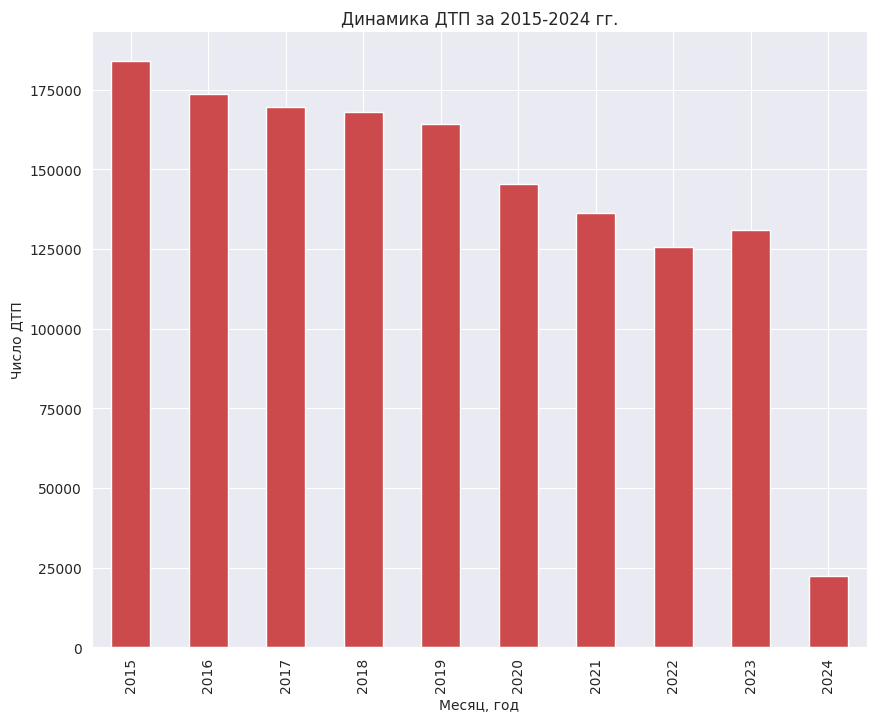

In [42]:
year_plot = merged_data['datetime'].dt.to_period("Y").sort_values().value_counts(
    sort=False)
year_plot
year_plot.plot(kind='bar', grid=True, figsize=[10, 8],color = '#CD4A4C')
plt.title('Динамика ДТП за 2015-2024 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП');

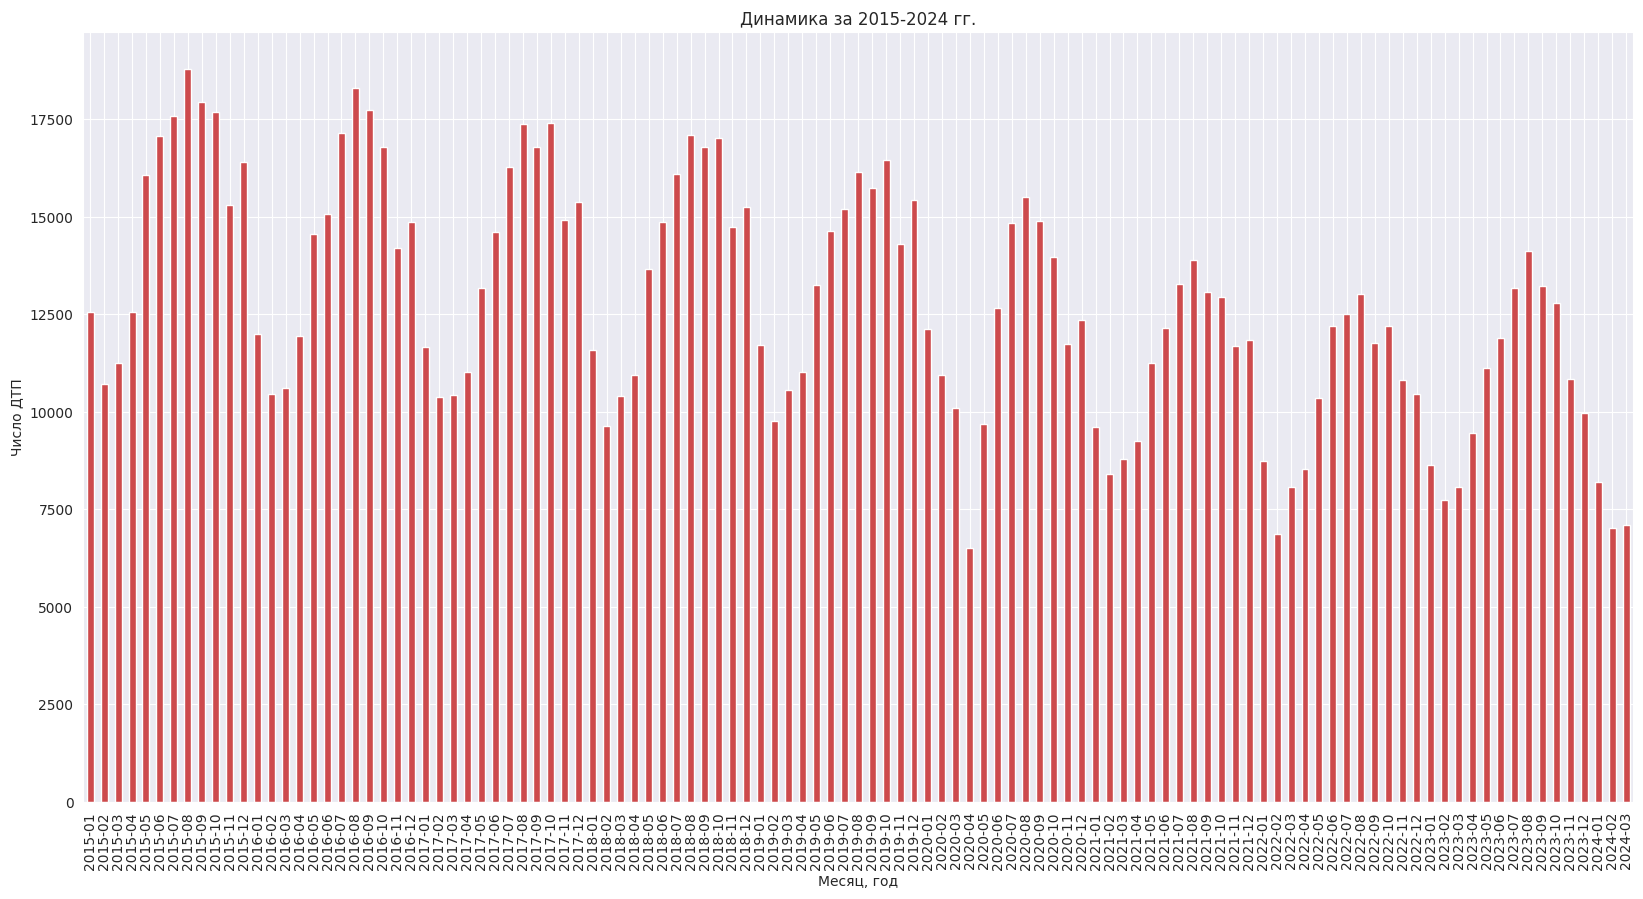

In [43]:
# Число ДТП по месяцам.

year_plot = merged_data['datetime'].dt.to_period("M").sort_values().value_counts(
    sort=False)
year_plot.plot(kind='bar', grid=True, figsize=[20, 10],color = '#CD4A4C')
plt.title('Динамика за 2015-2024 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП');

**На графике количества ДТП в разрезе времени наблюдается сезонность. Так с февраля количество ДТП начинает расти, пик приходится на середину лета и потом идет спад. Стоит отметить, что количество ДТП от года к году уменьшается, исключением стал 2023 год.**

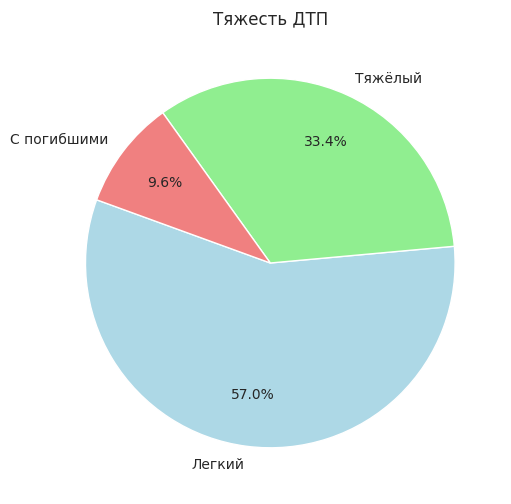

In [44]:
plt.figure(figsize=(6, 6))
merged_data['severity'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=160, pctdistance=0.72, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink'])
plt.title('Тяжесть ДТП')
plt.ylabel('')
plt.show()

**Более половины ДТП классифицируются как легкие. Только в 9.6% ДТП имеются погибшие.**

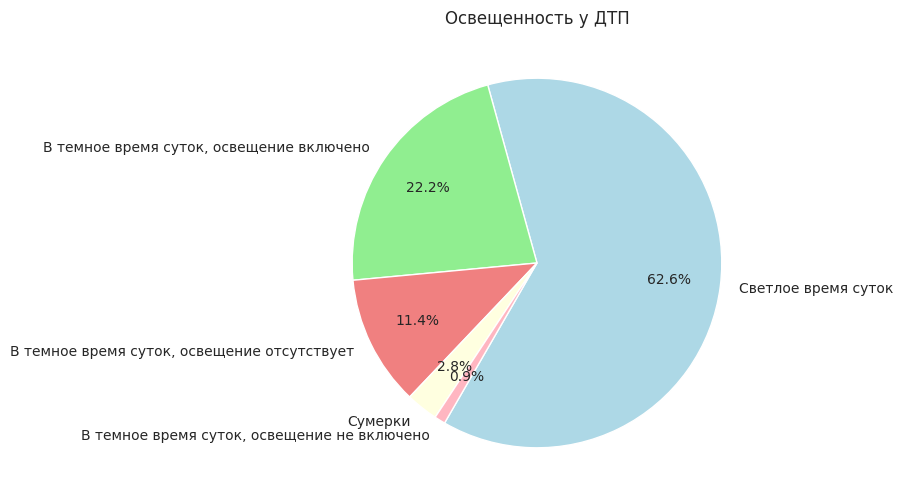

In [45]:
plt.figure(figsize=(6, 6))
merged_data['light'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=240, pctdistance=0.72,\
                                         colors=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink'])
plt.title('Освещенность у ДТП')
plt.ylabel('')
plt.show()

**62.6% ДТП в РФ происходили в светлое время суток и ещё 22.2% происходило в темное время с включённым освещением. Всего 15.2% ДТП происходили в темное время суток и/или с отсутствием освещения.**

In [46]:
severity_light = merged_data.groupby(['severity','light'])['category'].count().reset_index()

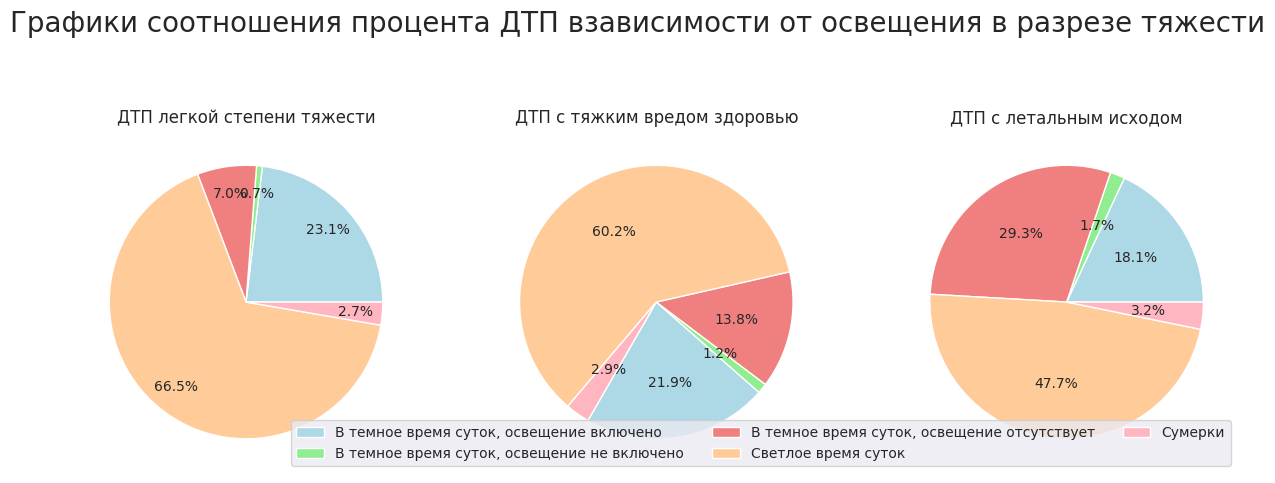

In [47]:

    labels = severity_light.light.unique().to_list()
    colors=['#add8e6', '#90ee90', '#f08080', '#ffcc99', '#ffb6c1']
    plt.figure(figsize=(15, 15))

    plt.suptitle('Графики соотношения процента ДТП взависимости от освещения в разрезе тяжести',fontsize = 20,y=0.9)
    # График 1
    plt.subplot(2, 3, 1)
    plt.pie(severity_light.loc[(severity_light['severity'] == "Легкий"), ['light','category']]['category'],colors=colors,pctdistance=0.8, autopct='%.1f%%')
    plt.title("ДТП легкой степени тяжести")

    # График 2
    plt.subplot(2, 3, 2)
    plt.pie(severity_light.loc[(severity_light['severity'] == "Тяжёлый"), ['light','category']]['category'],colors=colors, autopct='%.1f%%',startangle=240)
    plt.title("ДТП с тяжким вредом здоровью")

    # График 3
    plt.subplot(2, 3, 3)
    plt.pie(severity_light.loc[(severity_light['severity'] == "С погибшими"), ['light','category']]['category'],colors=colors, autopct='%.1f%%')
    plt.title("ДТП с летальным исходом")
    plt.legend(labels, loc='lower right',ncol=3)
    plt.show()

**На графика видно, что при снижении освещенности увеличивается тяжесть ДТП. Можно предположить, что участники дорожного движения не успевают во время среагировать, осуществить манёвр или сбросить скорость.**

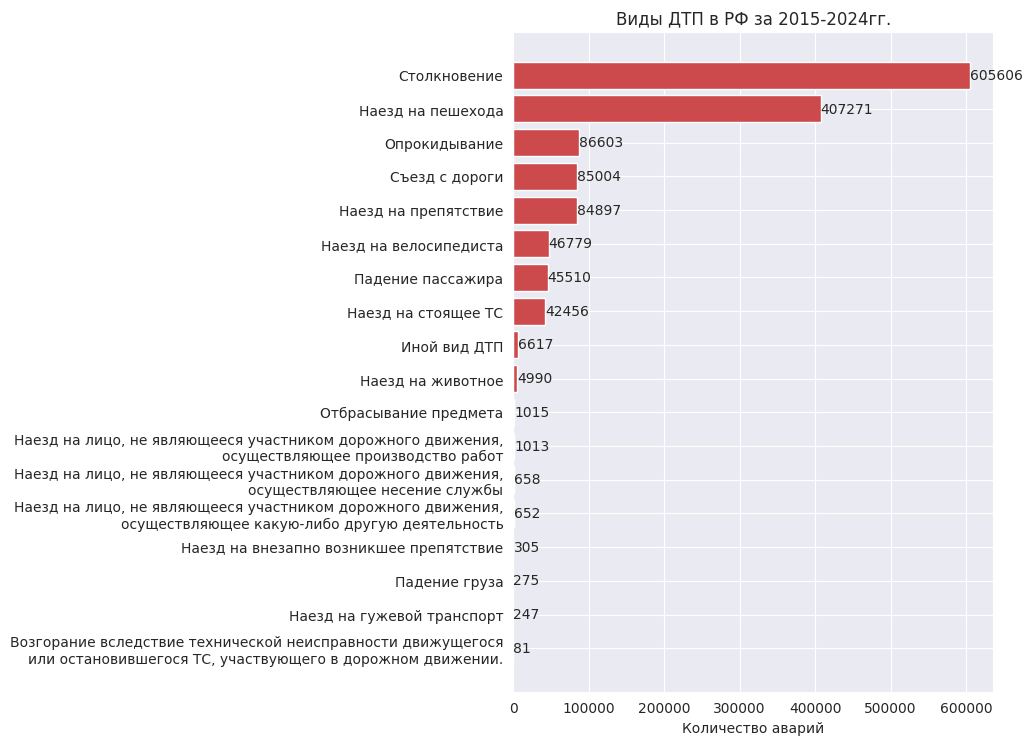

In [48]:
plt.figure(figsize=(6, 6))

# Построение столбчатой диаграммы
data = merged_data.groupby('category')['id'].count().reset_index().sort_values('id', ascending=True)
data['category'] = data['category'].apply(lambda x: textwrap.fill(x, width=60))
bars = plt.barh(data['category'], data['id'], color="#CD4A4C")

# Установка подписей осей и заголовка
plt.xlabel('Количество аварий')
plt.ylabel('')
plt.title('Виды ДТП в РФ за 2015-2024гг.')

# Добавление значений над каждым столбцом
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             '%d' % int(bar.get_width()),
             ha='left', va='center')

# Отображение графика
plt.subplots_adjust(left=0.1, right=0.9, top=1.2, bottom=0.1)
plt.show()

**Существенно преобладают 2 категории ДТП:"Столкновение" и "Наезд на пешехода". На эти категории приходится 71.3% всех ДТП в России.**

**Также на шестом месте расположились ДТП с участием велосипедистов, можно проследить как увеличилось количество аварий с велосипедистами после ковидного периода, когда число доставок увеличилось и городская инфраструктура была не готова к такому росту спроса на велокурьеров.**

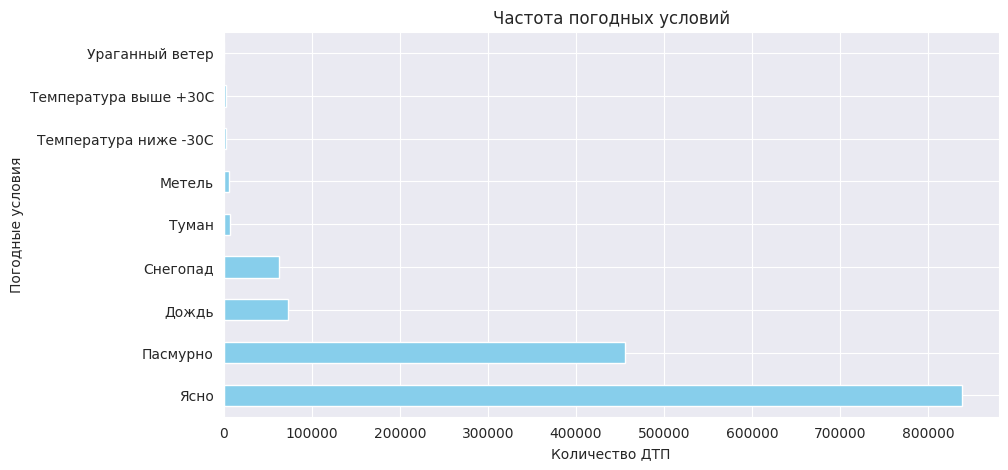

In [49]:
weather_list = merged_data['weather'].str.split(', ').explode()

# Считаем частоту погодных
weather_list = weather_list.value_counts()

# Построение гистограммы
plt.figure(figsize=(10, 5))
weather_list.plot(kind='barh', color='skyblue')
plt.xlabel('Количество ДТП')
plt.ylabel('Погодные условия')
plt.title('Частота погодных условий')
plt.show()

**Преимущественно ДТП происходят в ясную и пасмурную погоду. ДТП с участием атмосферных осадков не так много, либо сотрудники ГИБДД не всегда отмечают данную информацию.**

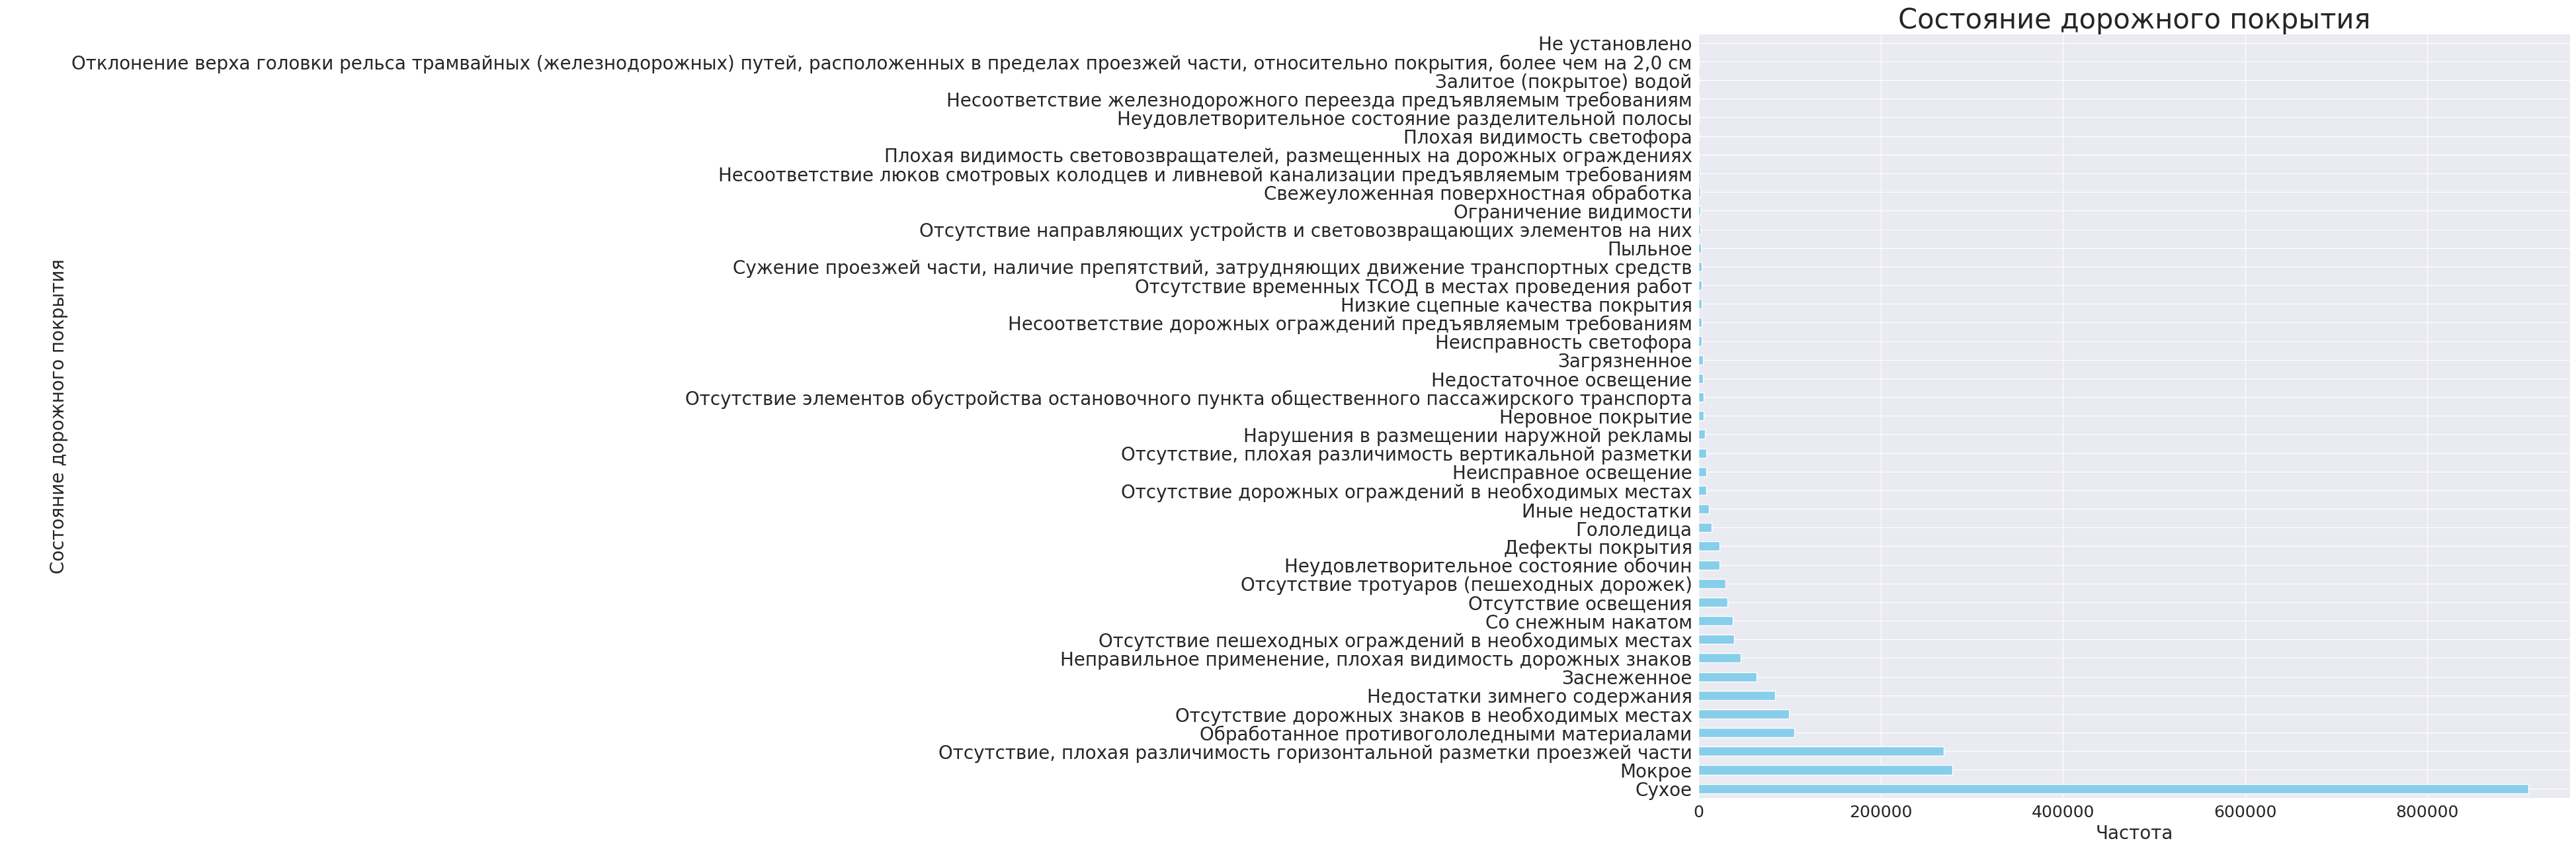

In [50]:
weather_list = merged_data['road_conditions'].explode().apply(lambda x: re.split(r',\s*(?=[А-Я])', x) if x[0].isupper() else [x]).explode()

# Считаем частоту погодных условий с помощью метода value_counts
weather_list = weather_list.value_counts()

# Построение гистограммы
plt.figure(figsize=(17, 15))
weather_list.plot(kind='barh', color='skyblue')
plt.xlabel('Частота',wrap=True, fontsize=20)
plt.ylabel('Состояние дорожного покрытия',wrap=True, fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=18)
plt.title('Состояние дорожного покрытия', fontsize=30)
plt.show()

**В большинстве аварий дорожное покрытие было сухим. На третьем месте по количеству ДТП отмечается отсутствие, плохая различимость горизонтальной разметки проезжей части, всего с таким состоянием дороги приходится более 200.000 ДТП.**

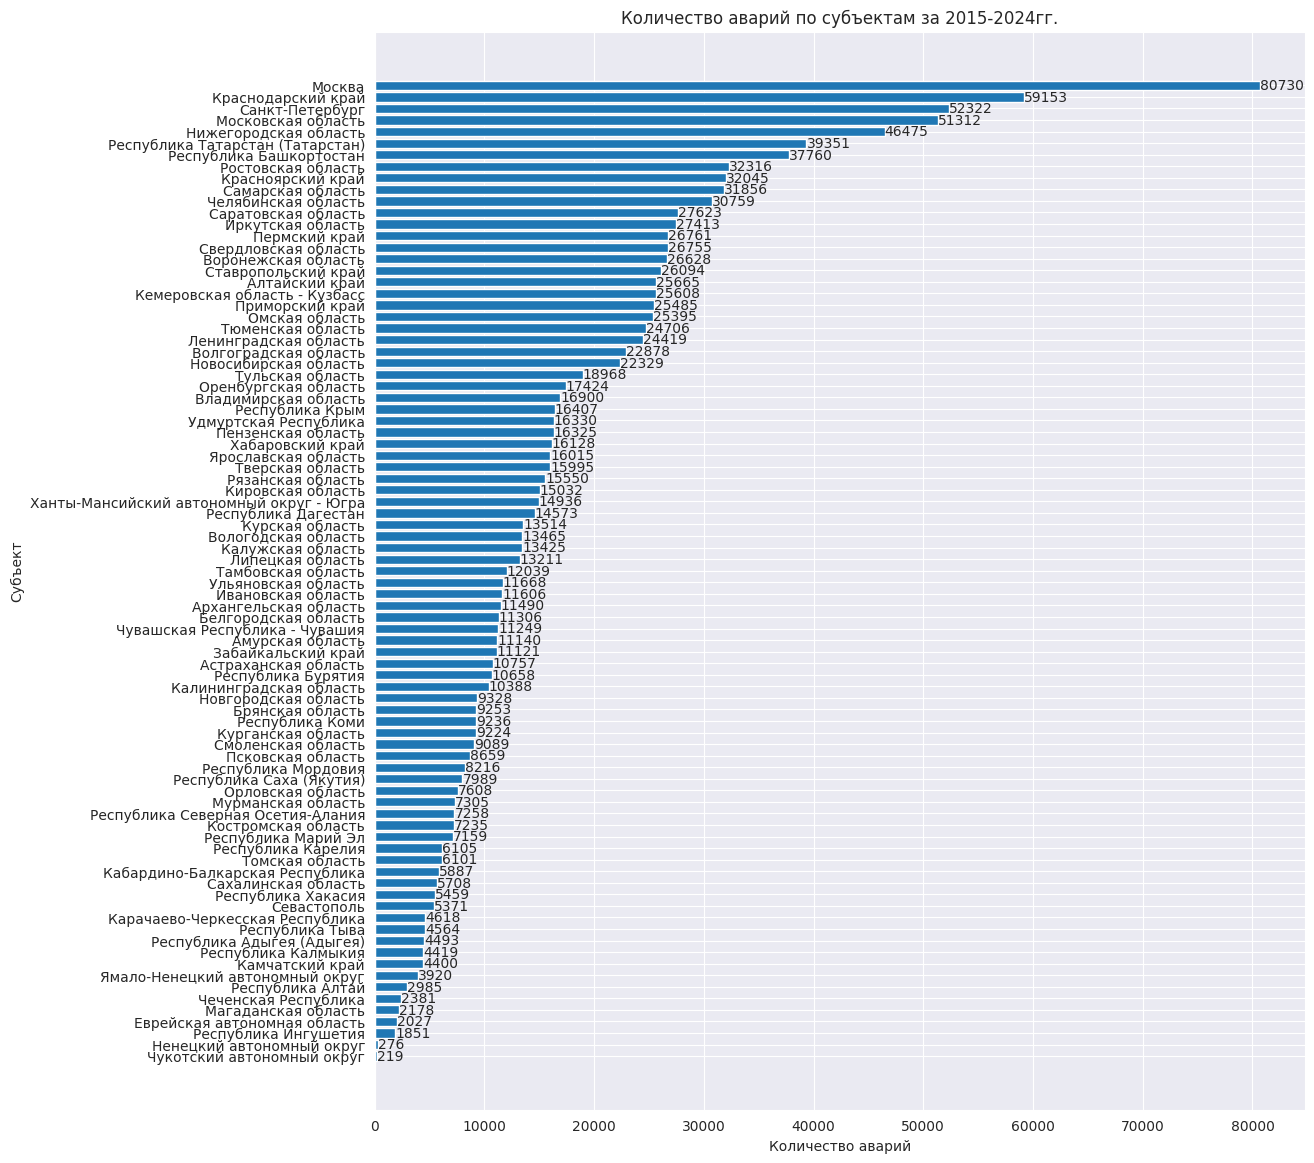

In [51]:
plt.figure(figsize=(12, 14))

# Построение столбчатой диаграммы
data = merged_data.groupby('parent_region')['id'].count().reset_index().sort_values('id', ascending=True)
bars = plt.barh(data['parent_region'], data['id'])

# Установка подписей осей и заголовка
plt.xlabel('Количество аварий')
plt.ylabel('Субъект')
plt.title('Количество аварий по субъектам за 2015-2024гг.')

# Добавление значений над каждым столбцом
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             '%d' % int(bar.get_width()),
             ha='left', va='center')

# Отображение графика
plt.show()

**В пятерку субъектов по количеству аварий входят: Москва, Краснодарский край, Санкт-Петербург, Московская область, Нижегородская область.**

**Стоит отметить, что Нижегородская область в отличие от остальных субъектов не входит даже в десятку регионов по численности населения, возможна такая высокая аварийность в регионе вызвана плохой транспортной инфраструктурой.**

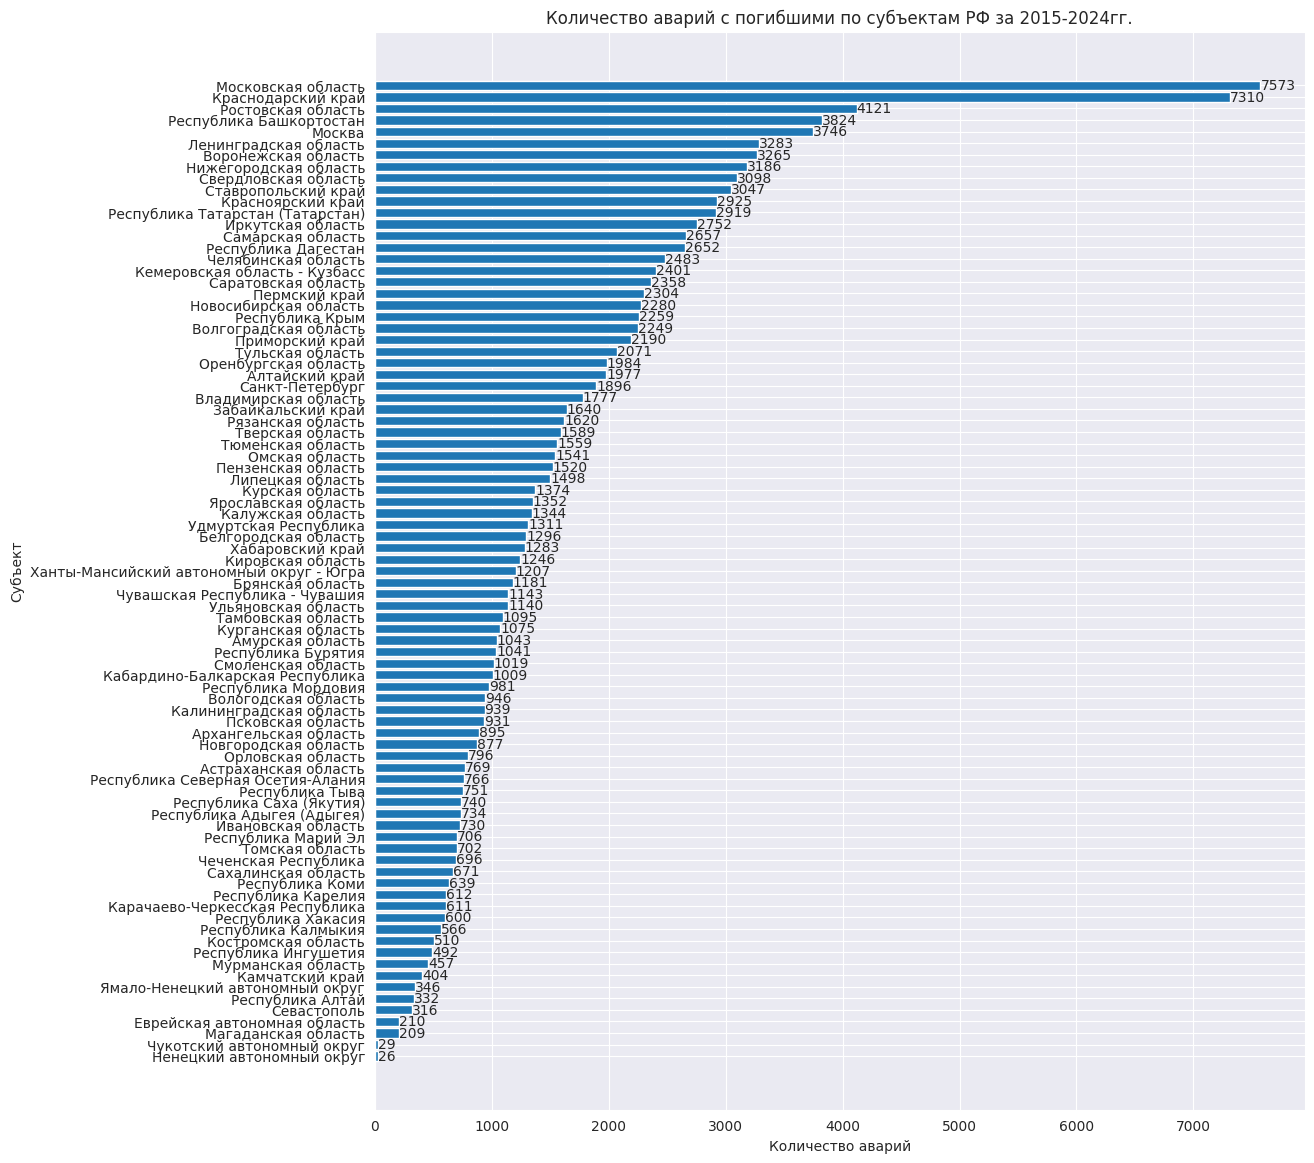

In [52]:
plt.figure(figsize=(12, 14))

# Построение столбчатой диаграммы
data = merged_data.query('severity=="С погибшими"').groupby('parent_region')['id'].count().reset_index().sort_values('id', ascending=True)
bars = plt.barh(data['parent_region'], data['id'])

# Установка подписей осей и заголовка
plt.xlabel('Количество аварий')
plt.ylabel('Субъект')
plt.title('Количество аварий с погибшими по субъектам РФ за 2015-2024гг.')

# Добавление значений над каждым столбцом
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             '%d' % int(bar.get_width()),
             ha='left', va='center')

# Отображение графика
plt.show()

**Пятерка лидеров по количеству аварий с погибшими отличается, от рейтинга субъектов по количеству аварий, в него входят: Московская область, Краснодарский край, Ростовская область, Республика Башкортостан, Москва.**

In [117]:
dt1 = merged_data.query('severity=="С погибшими"').groupby('parent_region').dead_count.sum().reset_index().sort_values('parent_region')
dt2 = merged_data.groupby('parent_region').participants_count.sum().reset_index().sort_values('parent_region')
dt1 = dt1.merge(dt2, on='parent_region', how='inner')
dt1['procent'] = round(dt1['dead_count']/dt1['participants_count']*100,2)
display(dt1.sort_values('procent', ascending=False))

,parent_region,dead_count,participants_count,procent
80,Чеченская Республика,930,6518,14.27
48,Республика Ингушетия,605,5416,11.17
47,Республика Дагестан,3448,40059,8.61
14,Кабардино-Балкарская Республика,1231,15721,7.83
43,Республика Адыгея (Адыгея),865,11231,7.70
...,...,...,...,...
31,Мурманская область,552,18301,3.02
36,Омская область,1848,63113,2.93
67,Севастополь,346,12932,2.68
29,Москва,4050,195180,2.08


**В процентном соотношении смертность в ДТП по регионам выглядит совсем иначе, в лидерах появляются кавказские регионы, так в Чеченской республике смертность в ДТП составляет 14%, в то время как у Москвы и Санкт-Петербурга самые низкие показатели 2% и 1%.**

**Возможно, высокая смертность в южных регионах связана со сложным рельефом или дорогами-серпантинами, либо местные водители чаще не соблюдают ПДД.**

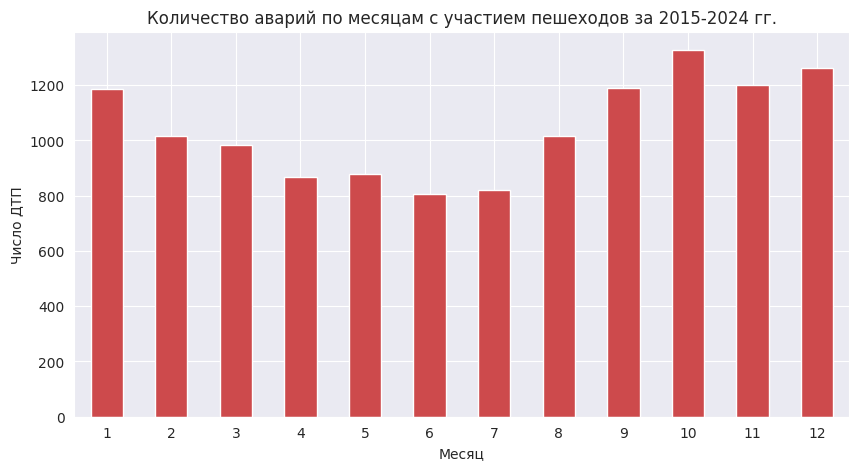

In [54]:
events_per_month = merged_data.query('traffic_accident_pedestrians==True')['datetime'].dt.month.value_counts().sort_index()
events_per_month.plot(kind='bar', grid=True, figsize=[10, 5],color = '#CD4A4C')
plt.title('Количество аварий по месяцам с участием пешеходов за 2015-2024 гг.')
plt.xlabel('Месяц')
plt.xticks(rotation=0)
plt.ylabel('Число ДТП');

**Наиболее опасными для пешеходов являются месяца, когда наступает межсезонье и похолодание. Возможно, не все водители во время успевают сменить резину, либо производится некачественная чистка дорог, что снижает сцепление с дорогой.**

**Так же пешеходы могут не заметить транспорт из-за осадков или маленького светового дня.**

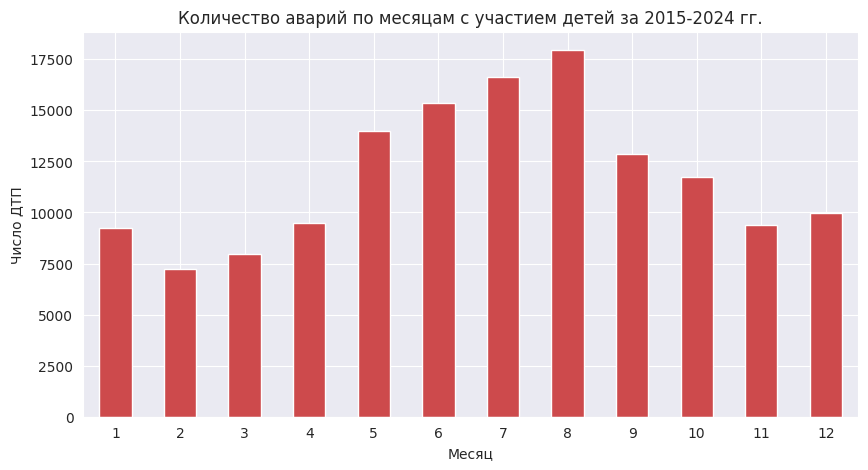

In [55]:
events_per_month = merged_data.query('traffic_accident_children==True')['datetime'].dt.month.value_counts().sort_index()
events_per_month.plot(kind='bar', grid=True, figsize=[10, 5],color = '#CD4A4C')
plt.title('Количество аварий по месяцам с участием детей за 2015-2024 гг.')
plt.xlabel('Месяц')
plt.xticks(rotation=0)
plt.ylabel('Число ДТП');

**Количество ДТП с участием детей сильно возрастает с мая по август. В это время у школьников начинаются каникулы, они больше времени проводят на улице и чаще становятся участниками ДТП.**

**В качестве рекомендации, можно предложить, сотрудникам ГИБДД проводить беседы со школьниками до летних каникул, а водителям быть более внимательными в эти месяцы. Вдобавок, обозначать участки дороги знаком "Дети" вблизи детских учреждений (школы, лагерей, кружков и т.д.) и другими средствами для упреждений ДТП.**

### Информация о машинах

Уменьшим категории ТС

In [56]:
df_car['category'] = df_car['category'].replace(['Мопеды с двигателем внутреннего сгорания менее 50 см. куб.',\
                                                 'Мопеды с электродвигателем менее 4 кВт', 'Мопеды с двигателем внутреннего сгорания более 50 см. куб.',\
                                                 'Мотороллеры','Мотовелосипеды','Квадрициклы','Трициклы'], 'Скутер, мопед, квадрицикл')

df_car['category'] = df_car['category'].replace(['Экскаваторы','Цистерны','Прочая спецтехника',\
                                                 'Оснащённые специализированным оборудованием автотранспортные средства аварийно-спасательных служб и полиции',\
                                                 'Автомобили скорой медицинской помощи','Автокраны и транспортные средства, оснащенные кранами-манипуляторами',\
                                                 'Фронтальные погрузчики','Специализированная снегоуборочная техника',\
                                                 'Автоцементовозы', 'Автобетоносмесители',\
                                                 'Оснащённые специализированным оборудованием  автотранспортные средства для коммунального хозяйства и  содержания дорог',\
                                                 'Рефрижераторы','Медицинские комплексы на шасси транспортных средств','Автогрейдеры',\
                                                 'Автоэвакуаторы','Транспортные средства, оснащенные подъемниками с рабочими платформами',\
                                                 'Спецтехника (без типа)','Пожарные автомобили','Транспортные средства для перевозки нефтепродуктов',\
                                                 'Иные дорожно-строительные и дорожно-эксплуатационные машины и механизмы',\
                                                 'Транспортные средства для перевозки денежной выручки и ценных грузов',\
                                                 'Специализированная техника военного назначения',
                                                 'Специализированная техника МВД','Боевая техника','Транспортные средства для перевозки пищевых жидкостей',\
                                                 'Автолесовозы','Специализированная техника аварийно-спасательного назначения',\
                                                 'Транспортные средства для перевозки сжиженных углеводородных газов на давление до 1,8 Мпа',\
                                                 'Автогудронаторы','Транспортные средства для обслуживания нефтяных и  газовых скважин',\
                                                 'Автобетононасосы','Транспортные средства оперативно-служебные для перевозки лиц, находящихся под стражей',\
                                                 'Самоходные машины и механизмы сельскохозяйственного назначения','Шасси'], 'Спец.техника')

df_car['category'] = df_car['category'].replace(['С-класс (малый средний, компактный) до 4,3 м','D-класс (средний) до 4,6 м','В-класс (малый) до 3,9 м',\
                                                 'Е-класс (высший средний, бизнес-класс) до 4,9 м',\
                                                 'Фургоны','Минивэны и универсалы повышенной вместимости',\
                                                 'Прочие легковые автомобили',\
                                                 'А-класс (особо малый) до 3,5 м','Легковые автомобили (без типа)',\
                                                 'S-класс (высший, представительский класс) более 4,9 м','Мотоколяски','Спортивные (гоночные)',\
                                                 'Автодома'], 'Легковой автомобиль')

df_car['category'] = df_car['category'].replace(['Бортовые грузовые автомобили','Седельные тягачи','Прочие грузовые автомобили',\
                                                 'Самосвалы',\
                                                 'Бортовые','Транспортные средства для перевозки длинномерных грузов',\
                                                 'Грузовые автомобили (без типа)',\
                                                 'Карьерные самосвалы','Тягачи'], 'Грузовой автомобиль')

df_car['category'] = df_car['category'].replace(['Прицепы к легковым автомобилям','Полуприцепы прочие','Прицепы тракторные',\
                                                 'Прицепы прочие',\
                                                 'Полуприцепы-фургоны'], 'Прицепы')

df_car['category'] = df_car['category'].replace(['Иные мототранспортные средства','Мототранспорт (без типа)'], 'Мотоциклы')

df_car['category'] = df_car['category'].replace(['Одноэтажные длиной от 8 до 12 м','Одноэтажные длиной от 5 до 8 м',\
                                                 'Одноэтажные длиной не более 5 м','Трамваи', 'Троллейбусы','Прочие одноярусные',\
                                                 'Прочие одноэтажные','Одноэтажные, сочлененные длиной более 12 м',\
                                                 'Школьные автобусы', 'Двухярусные','Автобусы (без типа)','Транспортные средства для перевозки детей',\
                                                 'Электробусы','Двухэтажные'], 'Автобусы и иной пассажирский транспорт')

df_car['category'] = df_car['category'].replace(['Прочие','Не установлено',\
                                                 'Не установлено (без типа)','Прочие Типы ТС (без типа)',\
                                                 'Прочие самоходные машины и механизмы',\
                                                 'Самоходные мотоблоки'], 'Иные ТС')

df_car['category'] = df_car['category'].replace(['Тракторы','Квадроциклы',\
                                                 'Снегоходы','Бульдозеры','Мотонарты, аэросани'], 'Внедорожная техника')


In [57]:
df_car.loc[(df_car['category'] == "Подвижной состав ж/д"), 'brand'] = "Прочие марки ТС"
df_car.loc[(df_car['category'] == "Гужевой транспорт")&(df_car['brand'].isna()), 'brand'] = "Прочие марки ТС"
df_car.loc[(df_car['category'] == "Подвижной состав ж/д"), 'model'] = "Прочие марки и модели ТС"
df_car.loc[(df_car['category'] == "Гужевой транспорт")&(df_car['model'].isna()), 'model'] = "Прочие марки и модели ТС"

Опредлим русские авто по году выпуска и брендам.

In [58]:
df_car['rus_car'] = df_car.apply(lambda x: True if pd.notna(x['year']) and x['brand'] in ['ГАЗ',\
                                                                                          'МОСКВИЧ', 'ВАЗ', 'ПАЗ', 'ЛИАЗ',\
                                                                                          'УРАЛ', 'КАМАЗ', 'ИЖ','НефАЗ', 'ЛУИДОР',\
                                                                                          'ВИС', 'ЗИЛ','ТАГАЗ (TAGAZ)', 'КАВЗ', 'SEAZ',\
                                                                                          'БАЗ','ЗИД', 'СимАЗ',\
                                                                                          'ГОЛАЗ'] and x['year'] > 1991 else False, axis=1)

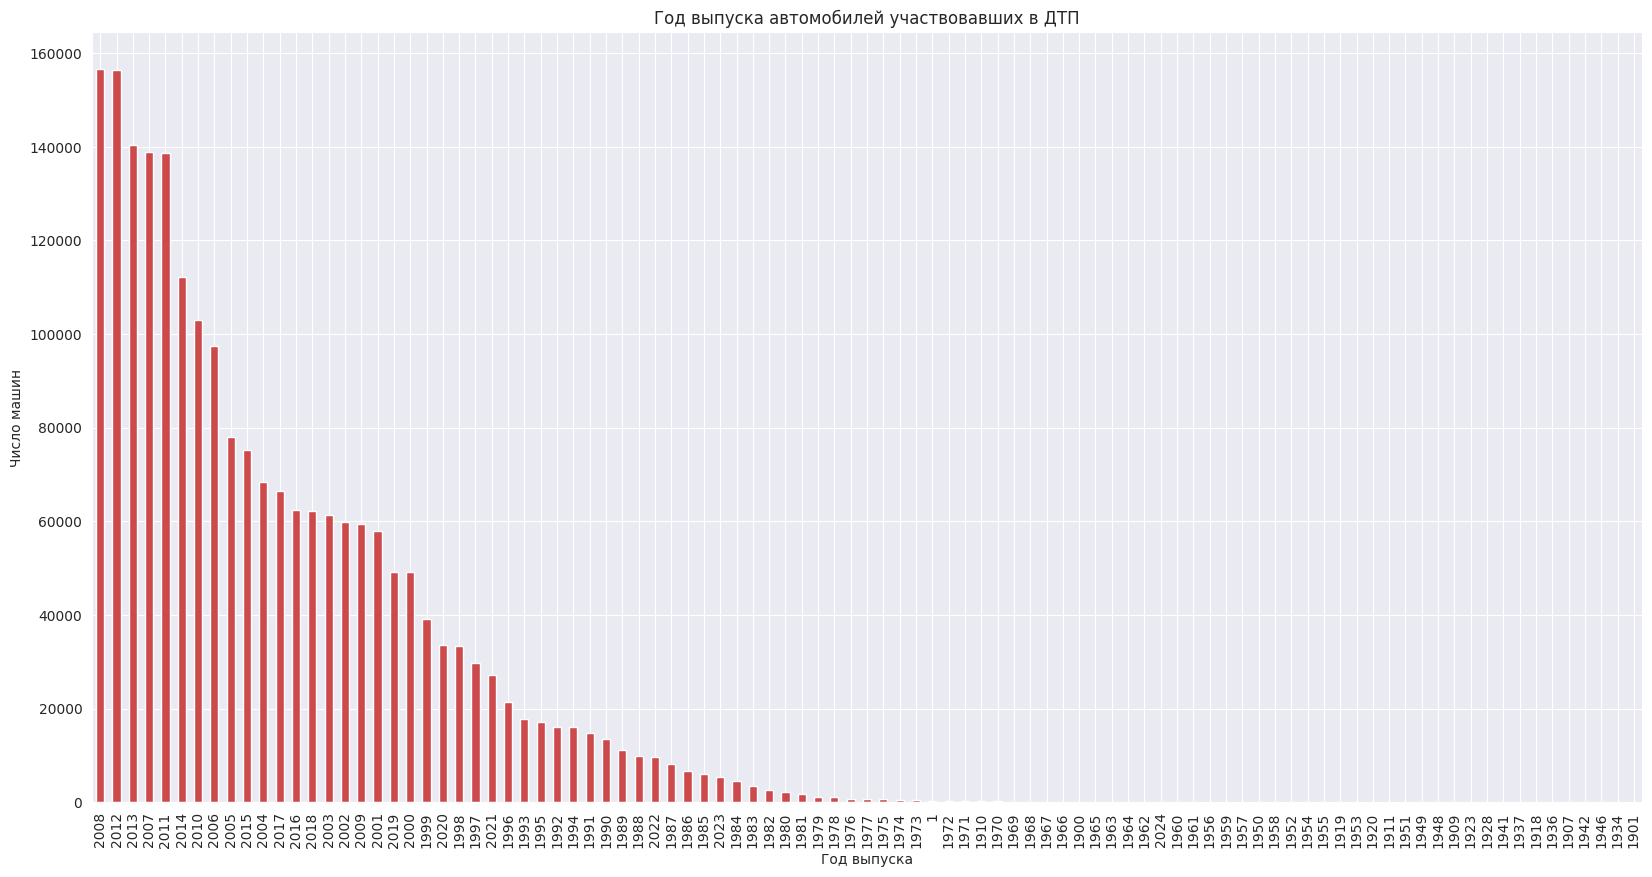

In [59]:
df_car.year.value_counts().plot(kind='bar', grid=True, figsize=[20, 10],color = '#CD4A4C')
plt.title('Год выпуска автомобилей участвовавших в ДТП')
plt.xlabel('Год выпуска')
plt.ylabel('Число машин');

**В основном в ДТП участвовали автомобили от 1978 года выпуска, что логично, более старые модели находятся уже на свалке или музеи, есть единичные ДТП с участием таких автомобилей.**

**В рейтинг 5 по году выпуска авто входят: 2008, 2012, 2013, 2007 и 2011.**


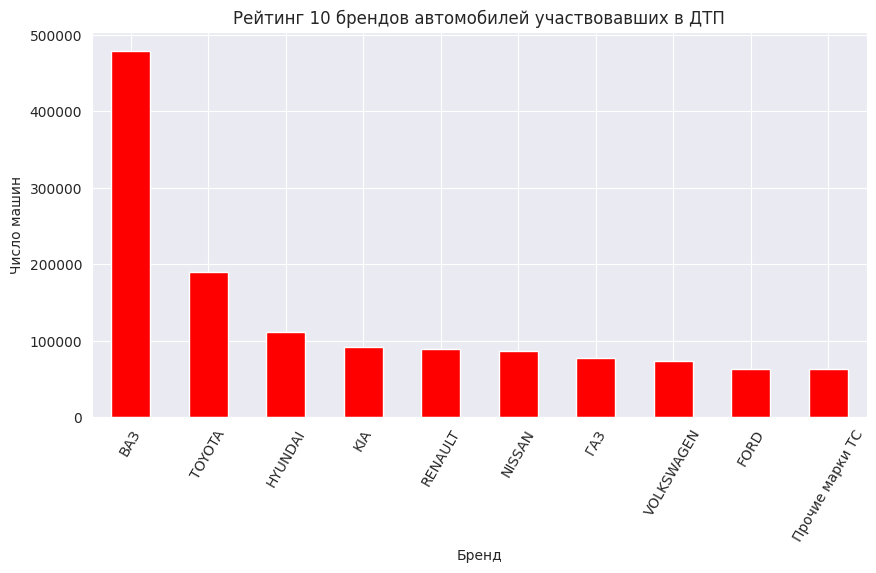

In [60]:
df_car.brand.value_counts().head(10).plot(kind='bar', grid=True, figsize=[10, 5],color = 'red')
plt.title('Рейтинг 10 брендов автомобилей участвовавших в ДТП')
plt.xlabel('Бренд')
plt.xticks(rotation=60)
plt.ylabel('Число машин');

**С большим отрывом идут автомобили бренда ВАЗ, нельзя сказать, что эти автомобили чаще других попадают в ДТП из-за технических проблем и т.д., данный график скорее отображает авторынок России.**

**Так ВАЗ занимает первое место из-за доступности автомобилей по их цене и ремонту, следовательно, это "народные" автомобили, которые чаще берут и они чаще попадают в ДТП.**

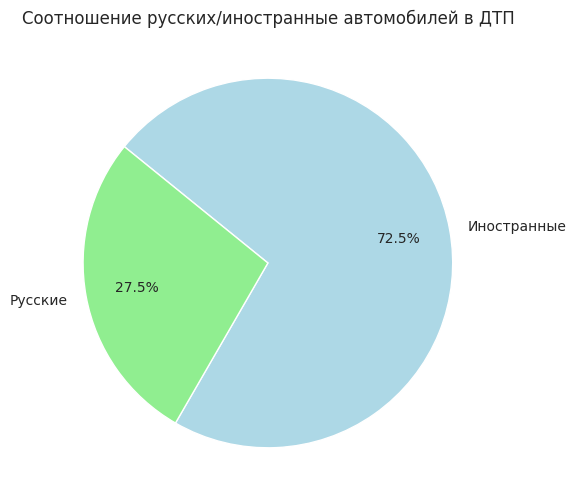

In [61]:
label_mapping = {True: 'Русские', False: 'Иностранные'}
plt.figure(figsize=(6, 6))
df_car['rus_car'].map(label_mapping).value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=240, pctdistance=0.72,\
                                         colors=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink'])
plt.title('Соотношение русских/иностранные автомобилей в ДТП')
plt.ylabel('')
plt.show()

**С учетом того, что на первое место по брендам занимал ВАЗ, все же большая часть авторынка России, состоит из иностранных брендов авто.**

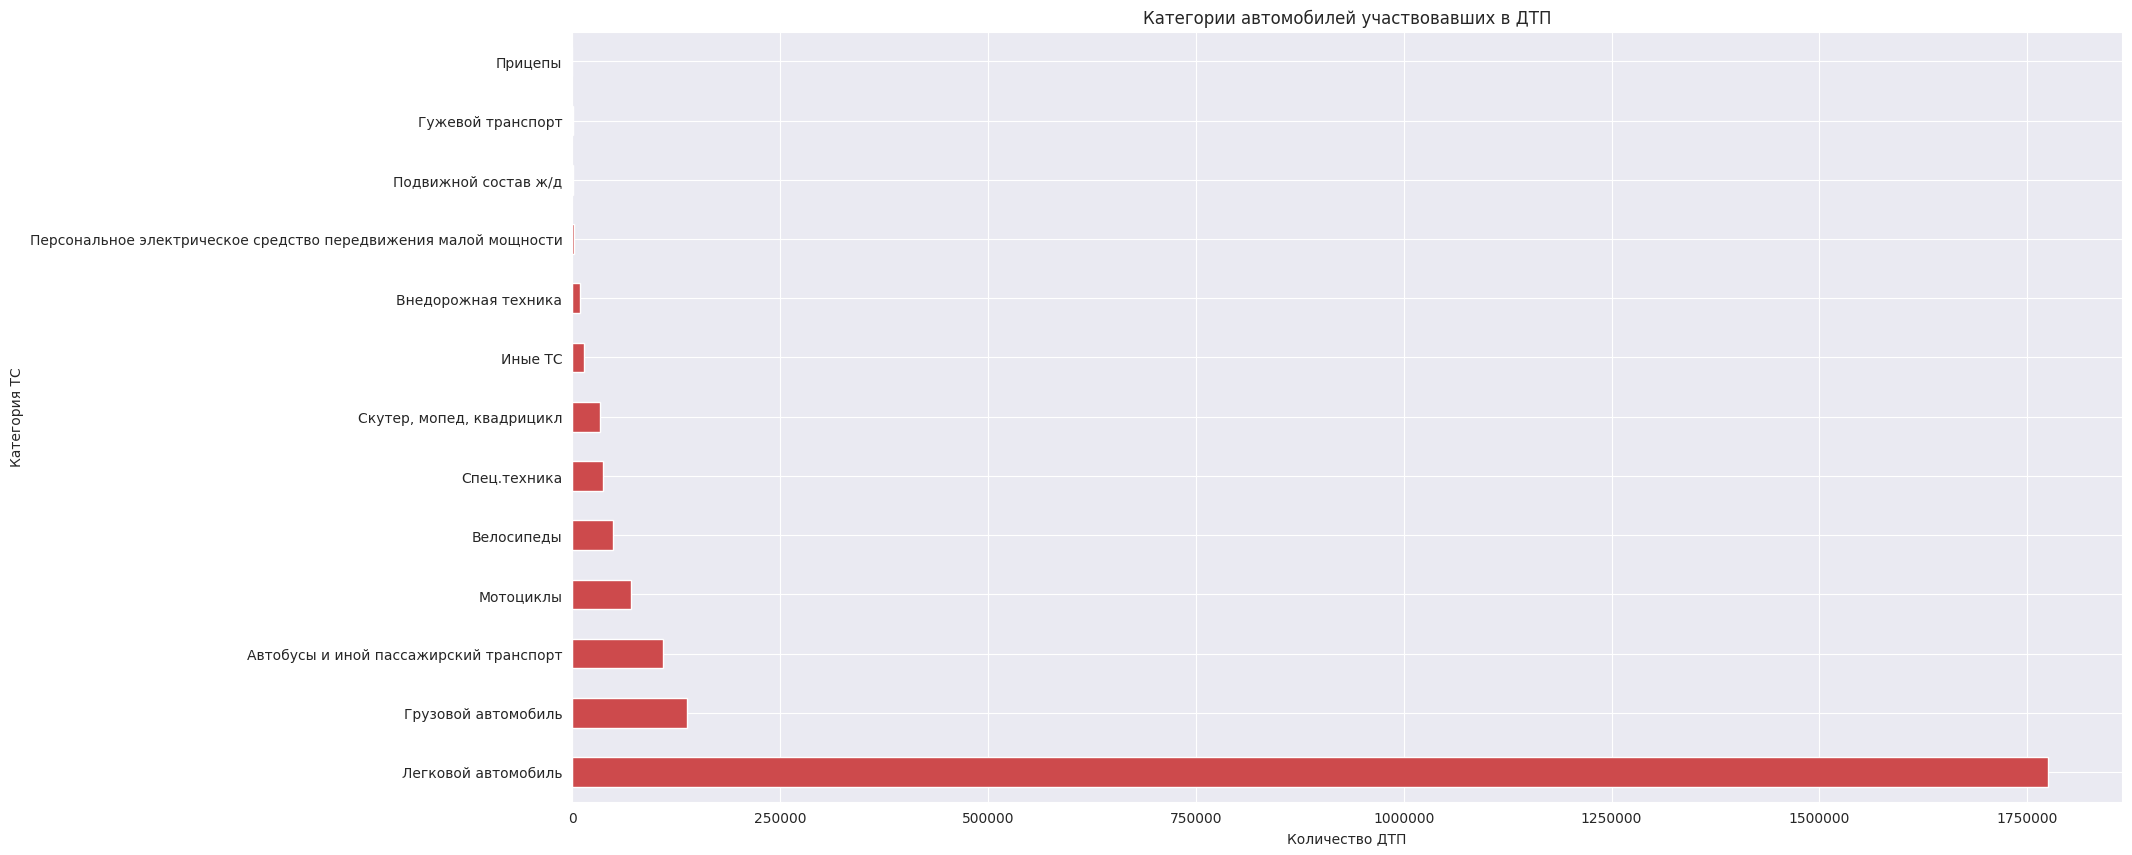

In [62]:
df_car.category.value_counts().plot(kind='barh', grid=True, figsize=[20, 10],color = '#CD4A4C')
plt.title('Категории автомобилей участвовавших в ДТП')
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel('Количество ДТП')
plt.ylabel('Категория ТС');

**В подавляющей большинстве в ДТП участвуют легковые автомобили. Следом с большим отставанием идут грузовые автомобили и автобусы и иной пассажирский транспорт.**

Отдельно просмотрим категории велосипеды и персональное электрическое средство(электросамокаты).

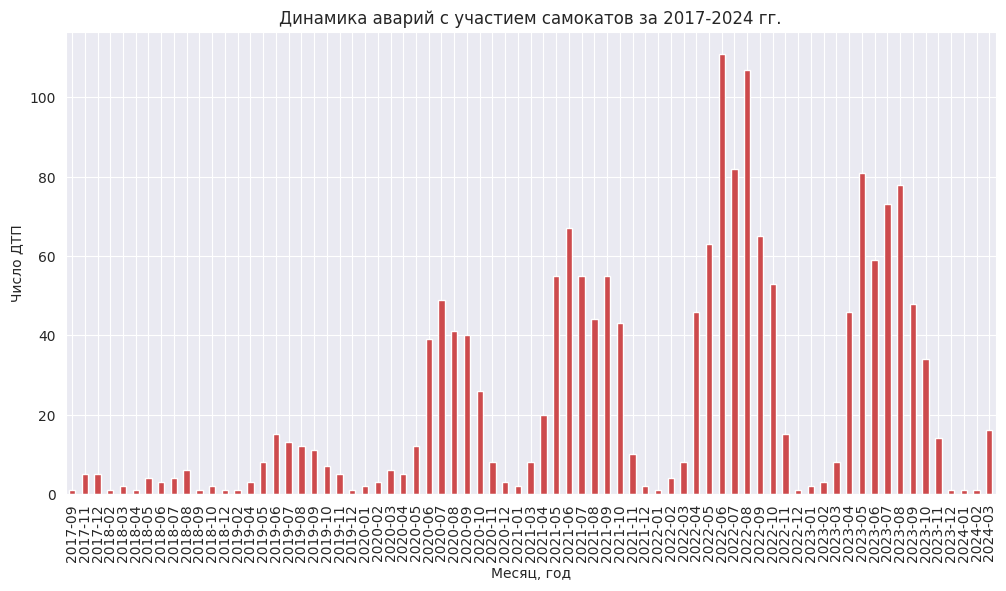

In [63]:
year_plot = df_car[df_car['category'].str.contains('Персональное электрическое', case=False, na=False)]\
  .merge(merged_data, on='id', how='inner')
year_plot = year_plot['datetime'].dt.to_period("M").sort_values().value_counts(
    sort=False)
year_plot.plot(kind='bar', grid=True, figsize=[12, 6],color = '#CD4A4C')
plt.title('Динамика аварий с участием самокатов за 2017-2024 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП');

**Видно, как спрос на электросамокаты постепенно рос и вошел в пик вовремя пандемии короновируса(роста доставок на дом), после пандемии количество аварий пошло на спад, но незначительно.**

**Количество ДТП с участием самокатов за все время — 1713. Но спрос на них сохраняется, с учетом того, что он может развить максимальную скорость в 80-100км/ч и на него нет возрастных ограничений, возможно, стоит пересмотреть допуск к данному виду транспорта и ввести на него требования прав категории М.**

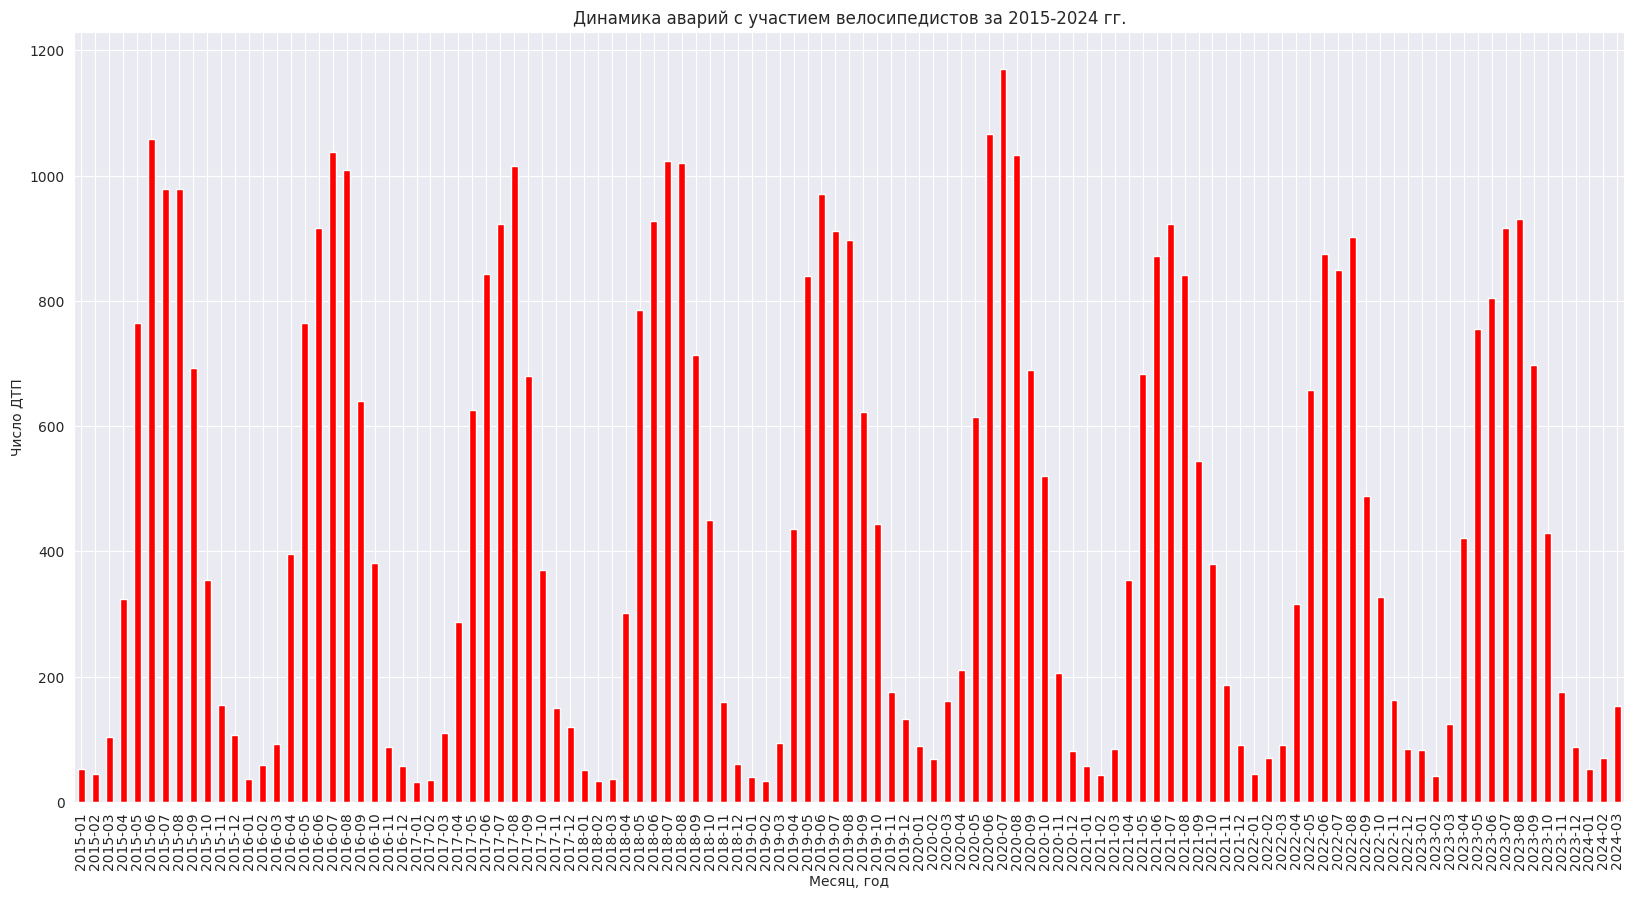

In [64]:
# Выбор нужных столбцов
year_plot = merged_data.query('cyclists==True ')['datetime'].dt.to_period("M").sort_values().value_counts(
    sort=False)
year_plot.plot(kind='bar', grid=True, figsize=[20, 10],color = 'red')
plt.title('Динамика аварий с участием велосипедистов за 2015-2024 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП');

**Количество ДТП с участием велосипедистов в после ковидное время уменьшилось, возможно, это связано с уменьшением потребности в доставках, так же видна сезонность, что вполне логично.**

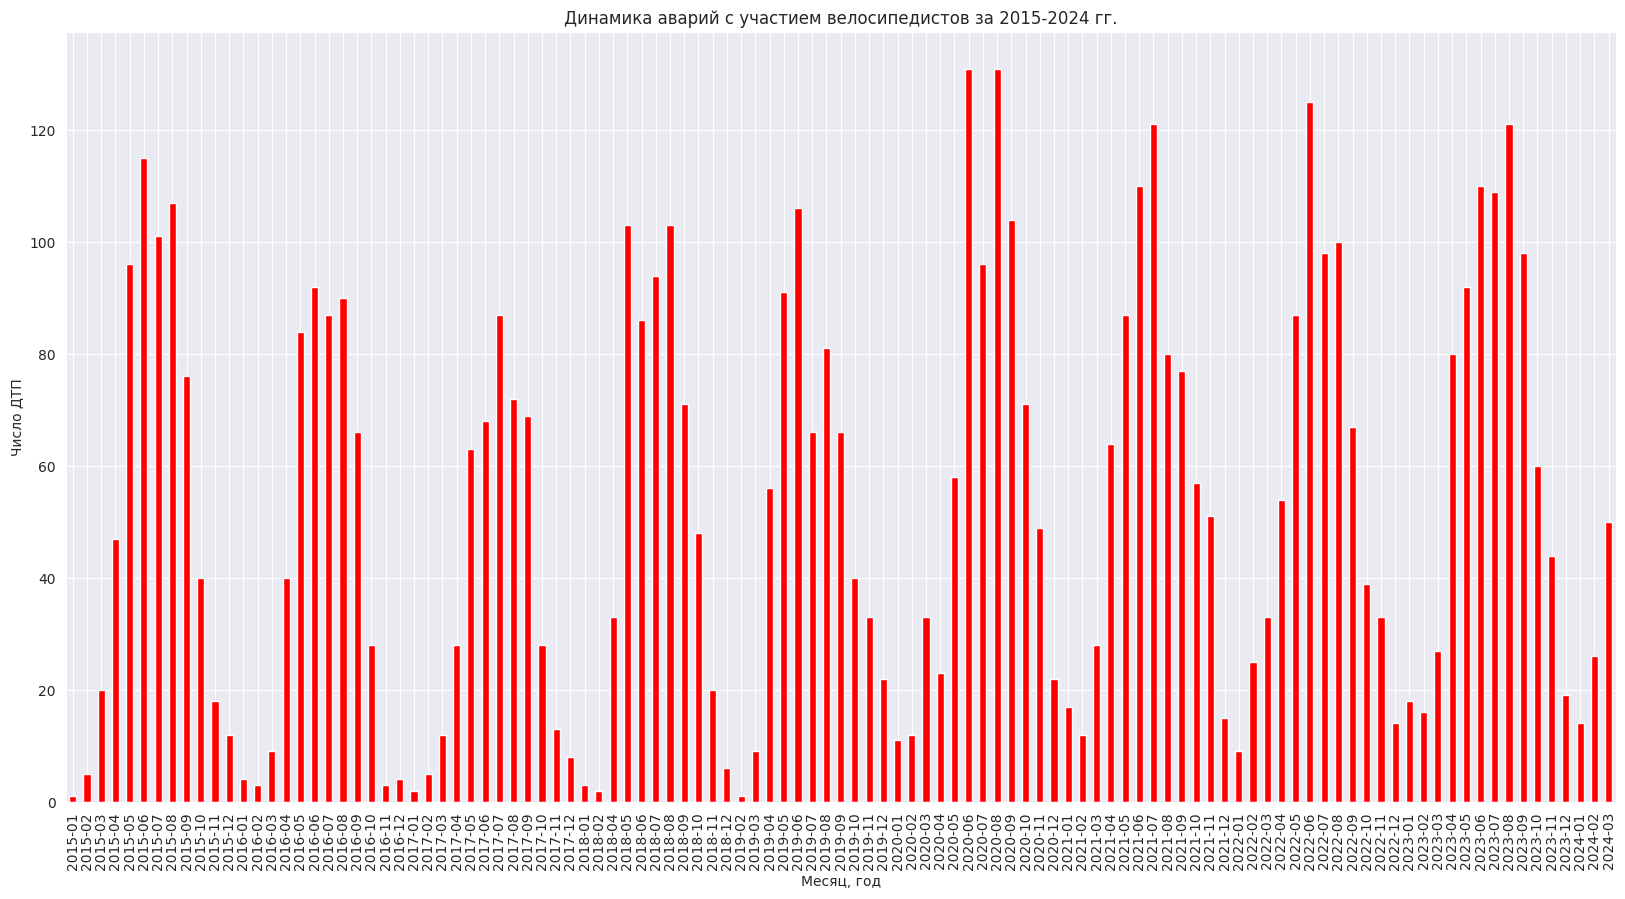

In [65]:
# Выбор нужных столбцов
year_plot = merged_data.query('cyclists==True and (parent_region=="Москва"or parent_region=="Санкт-Петербург")')['datetime'].dt.to_period("M").sort_values().value_counts(
    sort=False)
year_plot.plot(kind='bar', grid=True, figsize=[20, 10],color = 'red')
plt.title('Динамика аварий с участием велосипедистов за 2015-2024 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП');

**В Москве и Санкт-Петербурге, наблюдается обратная картина, в после ковидное время тема доставок осталась актуальной и участилось количество аварий с велосипедистами.**

**Возможно, работодателям необходимо производить инструктажи с участием сотрудников ГИБДД для снижения количества ДТП.**

### Информация о участниках ДТП

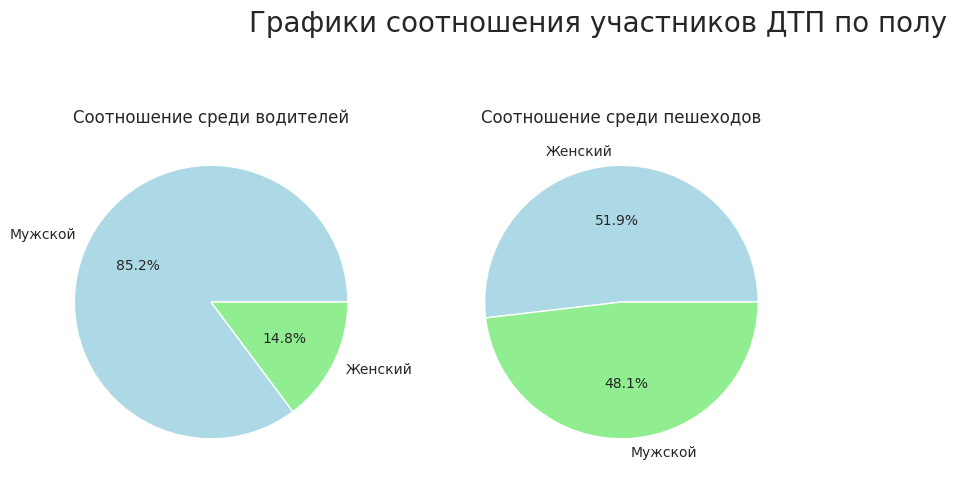

In [66]:
gender_driver = df_people.query('role=="Водитель"').gender.value_counts()
gender_pedestrian = df_people.query('role=="Пешеход"').gender.value_counts()
colors=['#add8e6', '#90ee90', '#f08080', '#ffcc99', '#ffb6c1']
plt.figure(figsize=(15, 15))
plt.suptitle('Графики соотношения участников ДТП по полу ',fontsize = 20,y=0.9)
plt.subplot(2, 3, 1)
plt.pie(gender_driver,colors=colors, autopct='%.1f%%',labels=gender_driver.index)
plt.title("Соотношение среди водителей")
# График 2
plt.subplot(2, 3, 2)
plt.pie(gender_pedestrian,colors=colors, autopct='%.1f%%',labels=gender_pedestrian.index)
plt.title("Соотношение среди пешеходов")

plt.show()

**Более 85% участников ДТП в качестве водителей были мужчины, но стоит отметить, что и водителей мужчин во много раз больше.**

**Участников ДТП в качестве пешеходов разделены почти поровну между мужчинами и женщинами.**

Уменьшим категории пострадавших

In [67]:
df_people['health_status'] = df_people['health_status'].replace(['Скончался в течение 1 суток','Скончался в течение 2 суток',\
                                                 'Скончался в течение 3 суток','Скончался в течение 4 суток',\
                                                  'Скончался в течение 5 суток','Скончался в течение 6 суток',\
                                                  'Скончался в течение 7 суток','Скончался в течение 8 суток',\
                                                   'Скончался в течение 9 суток','Скончался в течение 11 суток','Скончался в течение 12 суток',\
                                                 'Скончался в течение 13 суток','Скончался в течение 14 суток',\
                                                  'Скончался в течение 15 суток','Скончался в течение 16 суток',\
                                                  'Скончался в течение 17 суток','Скончался в течение 18 суток',\
                                                   'Скончался в течение 19 суток','Скончался в течение 21 суток','Скончался в течение 22 суток',\
                                                 'Скончался в течение 23 суток','Скончался в течение 24 суток',\
                                                  'Скончался в течение 25 суток','Скончался в течение 26 суток',\
                                                  'Скончался в течение 27 суток','Скончался в течение 28 суток',\
                                                   'Скончался в течение 29 суток','Скончался в течение 10 суток',\
                                                                 'Скончался в течение 20 суток'], 'Скончался в течение 30 суток')
df_people['health_status'] = df_people['health_status'].replace(['Скончался на месте ДТП до приезда скорой медицинской помощи',\
                                        'Скончался на месте ДТП по прибытию скорой медицинской помощи, но до транспортировки в медицинское учреждение',\
                                                 'Скончался на месте ДТП по прибытию скорой медицинской помощи, но до транспортировки в мед. организацию','Скончался на месте ДТП','Скончался при транспортировке'],\
                                                                'Скончался в течение 30 суток')
df_people['health_status'] = df_people['health_status'].replace(['Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)',\
                                        'Раненый, находящийся (находившийся) на стационарном лечении',\
                                                 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара',\
                                                                 'Получил телесные повреждения с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)'],\
                                                                'Раненый')
df_people['health_status'] = df_people['health_status'].replace(['Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится',\
                                        'Получил телесные повреждения с показанием к лечению в медицинских организациях, фактически лечение не проходил, к категории раненый не относится'],\
                                                                'Получил повреждения, к категории раненый не относится ')

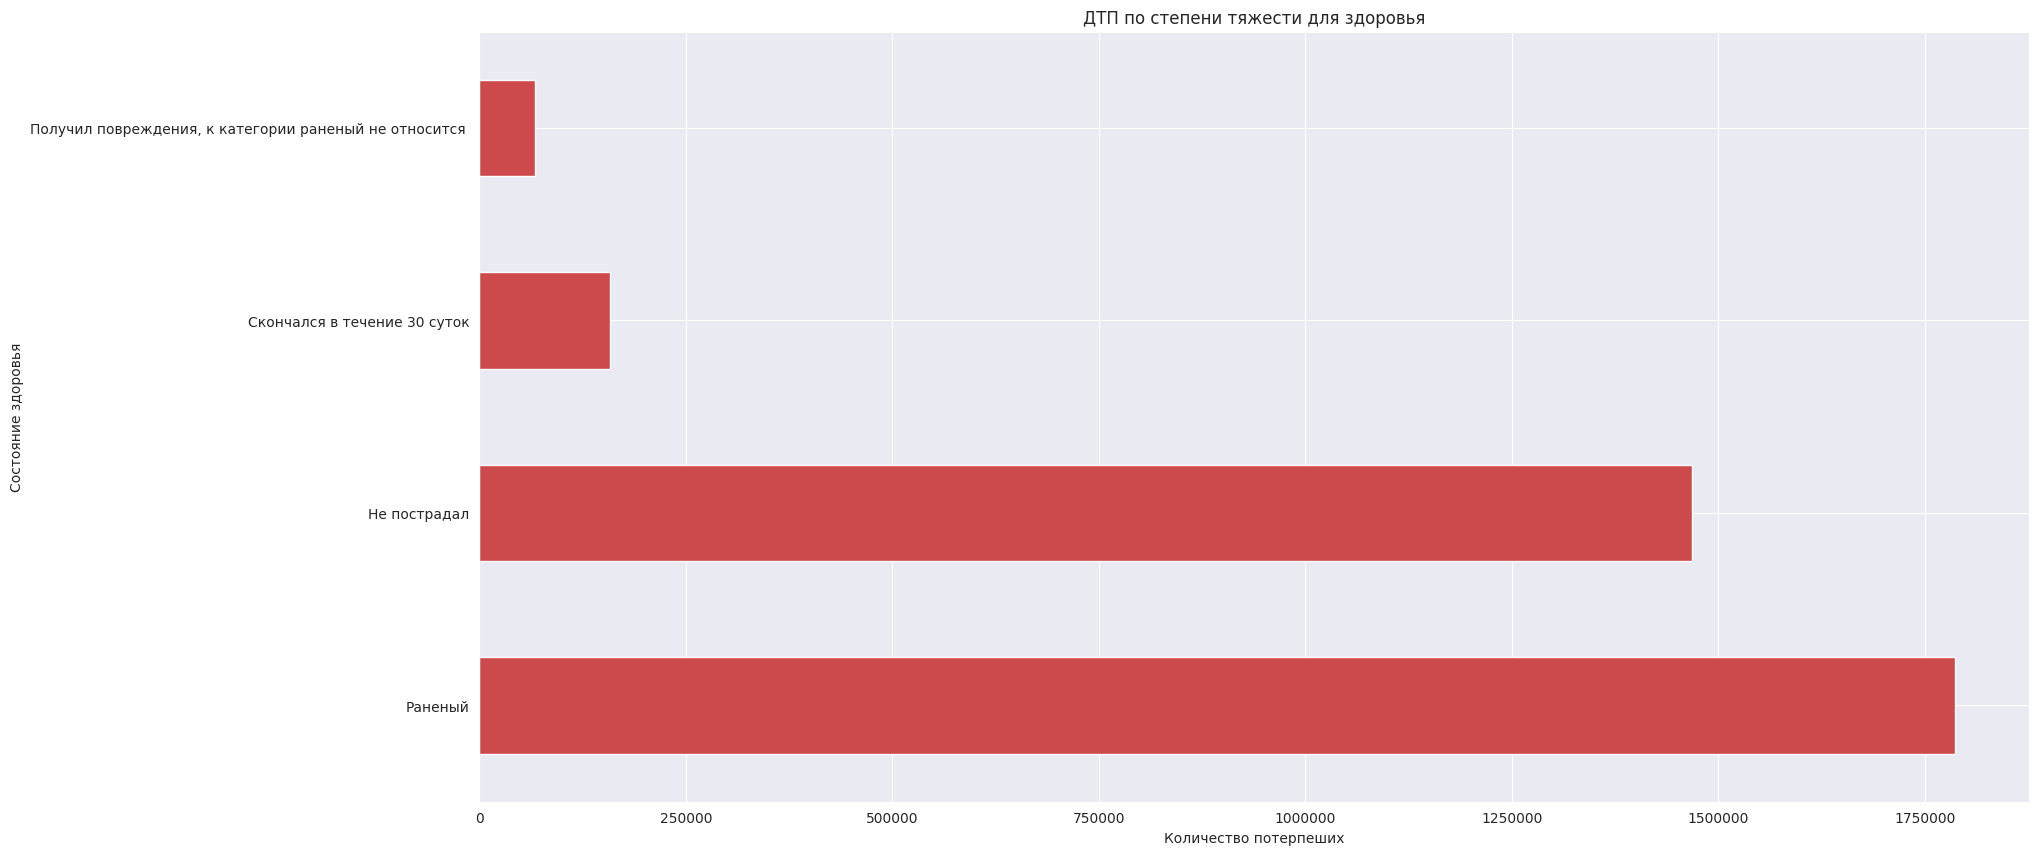

In [68]:
df_people.health_status.value_counts().plot(kind='barh', grid=True, figsize=[20, 10],color = '#CD4A4C')
plt.title('ДТП по степени тяжести для здоровья')
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel('Количество потерпеших')
plt.ylabel('Состояние здоровья');

**В большинстве ДТП участников относят к категории раненых или не пострадавших. С 2015.01-2024.02 более 1.750.000 участников ДТП отнесли к категории раненых.**

In [69]:
#Функция позволяет убрать списки
def join_violations(x):
    if isinstance(x, list):
        return ', '.join(map(str, x))
    else:
        return ''

df_people['violations'] = df_people['violations'].apply(join_violations)

In [70]:
replace_dict = {'Другие нарушения ПДД водителем':'Другие нарушения ПДД водителями (не применяется с 12.2020)',\
            'Нарушение\xa0правил\xa0движения тяжеловесного и(или) крупногабаритного ТС(превышение допустимых габаритов ТС, превышением допустимой массы ТС или допустимой нагрузки на ось ТС)':\
            'Нарушение правил движения тяжеловесного и(или) крупногабаритного ТС(превышение допустимых габаритов ТС, превышением допустимой массы ТС или допустимой нагрузки на ось ТС)',\
            'Отказ водителя, не имеющего права управления ТС либо лишенного права управления ТС от прохождении медицинского освидетельствования на состояние опьянения':\
            'Отказ водителя, не имеющего права управления ТС либо лишенного права управления ТС, от прохождения медицинского освидетельствования на состояние опьянения (не применяется с 12.2020)',\
            'Неподача или неправильная подача сигналов поворота':'Неподача или неправильная подача сигналов',\
            'Управление ТС лицом, находящимся в состоянии алкогольного опьянения и не имеющим права управления ТС либо лишенным права управления ТС (не применяется с 12.2020)':\
            'Управление ТС лицом, находящимся в состоянии алкогольного опьянения и не имеющим права управления ТС либо лишенным права управления ТС',\
            'Управление ТС лицом, находящимся в состоянии наркотического опьянения и не имеющим права управления ТС либо лишенным права управления ТС (не применяется с 12.2020)':\
            'Управление ТС лицом, находящимся в состоянии наркотического опьянения и не имеющим права управления ТС либо лишенным права управления ТС',\
}

replace_dict2={'Управление ТС лицом, находящимся в состоянии алкогольного опьянения и не имеющим права управления ТС либо лишенным права управления ТС':\
              'Управление ТС лицом, находящимся в состоянии алкогольного опьянения и не имеющим права управления ТС либо лишенным права управления ТС (не применяется с 12.2020)',
                'Управление ТС лицом, находящимся в состоянии наркотического опьянения и не имеющим права управления ТС либо лишенным права управления ТС':\
                'Управление ТС лицом, находящимся в состоянии наркотического опьянения и не имеющим права управления ТС либо лишенным права управления ТС (не применяется с 12.2020)'}
#Заменяем в строках значения
def replace_substrings(text, replace_dict):
    sorted_keys = sorted(replace_dict, key=len, reverse=True)
    for old_value in sorted_keys:
        new_value = replace_dict[old_value]
        text = text.replace(old_value, new_value)
    return text


In [71]:
df_people['violations'] = df_people['violations'].apply(lambda x: replace_substrings(x, replace_dict))
df_people['violations'] = df_people['violations'].apply(lambda x: replace_substrings(x, replace_dict2))

In [72]:
unique_values = df_people.query('role=="Водитель" and violations!=""')['violations']\
  .apply(lambda x: re.split(r',\s*(?=[А-Я])', x) if x[0].isupper() else [x]).explode().str.strip().value_counts()

display(unique_values.head(10))

violations
Несоблюдение требований ОСАГО                                 267490
Другие нарушения ПДД водителями (не применяется с 12.2020)    235847
Несоблюдение очередности проезда                              180641
Несоответствие скорости конкретным условиям движения          160199
Нарушение правил расположения ТС на проезжей части            139094
Оставление места ДТП                                          136855
Неправильный выбор дистанции                                  136539
Нарушение правил проезда пешеходного перехода                 129414
Управление ТС в состоянии алкогольного опьянения              109270
Управление ТС лицом, не имеющим права на управление ТС        105928
Name: count, dtype: int64

**Самое часто встречающиеся нарушение у водителей — это "несоблюдение требований ОСАГО".**

**На 7 и 8 месте популярности идут нарушения, которые серьёзно влияют на безопасность пешеходов — это "Нарушение правил проезда пешеходного перехода" и "Управление ТС в состоянии алкогольного опьянения".**

In [73]:
unique_values = df_people.query('role=="Пешеход" and violations!=""')['violations']\
  .apply(lambda x: re.split(r',\s*(?=[А-Я])', x) if x[0].isupper() else [x]).explode().str.strip().value_counts()

print(unique_values.head(10))

violations
Переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной близости подземного (надземного) пешеходного перехода    60013
Переход через проезжую часть в неустановленном месте (при наличии в зоне видимости перекрёстка)                                                                         30515
Иные нарушения                                                                                                                                                          27107
Нахождение на проезжей части без цели её перехода                                                                                                                       18185
Пешеход в состоянии алкогольного опьянения                                                                                                                              16752
Неподчинение сигналам регулирования                                                                                    

**У пешеходов, самыми частыми нарушениями являются: переход дороги в неположенном месте и неожиданные выходы на дорогу из-за различных объектов.**

**На 7 месте идет нарушение "Отсутствие световозвращающих элементов", скорее всего это касается сотрудников находящихся на дороге и выполняющих какие-либо ремонтные работы. В качестве предотвращения этого нарушения на предприятиях необходимо соблюдать ТБ и проводить инструктаж работников работающих на дорогах, особенно в ночное время.**

## Проверка гипотез

### Влияния ужесточения законов для нетрезвых водителей

За последнее время можно отметить два закона вносящие серьезные поправки в отношении водителей находящихся в алкогольном или наркотическом опьянении:


*   17 июня 2019 года внесены поправки в Уголовный кодекс РФ, ужесточающие наказание для нетрезвых водителей за дорожно-транспортные происшествия приведшие к гибели людей.
*   1 июля 2021 года внесены поправки: увеличены штрафы за повторное вождение в нетрезвом виде, лишение водительских прав на три года, может быть применено наказание вплоть до двух лет лишения свободы.

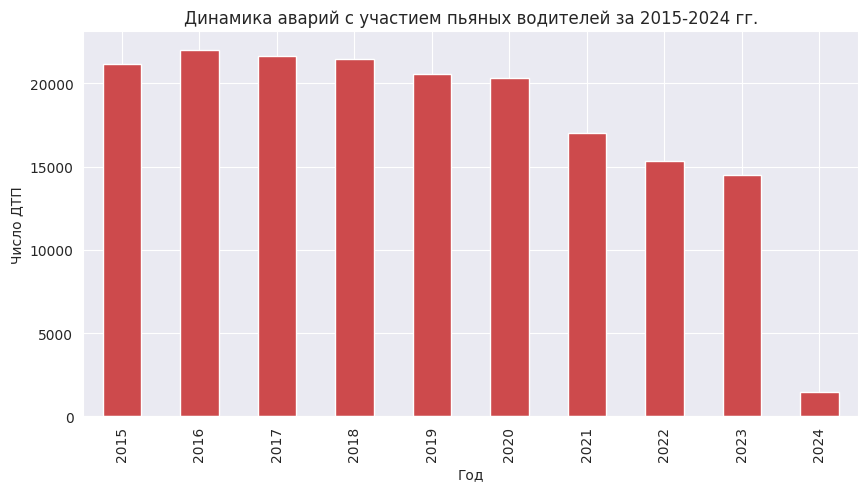

In [74]:
# Выбор нужных столбцов
year_plot = df_people[df_people['violations'].str.contains('опьянен|алког', case=False, na=False)].\
  query('role=="Водитель"').merge(merged_data, on='id', how='inner')
year_plot = year_plot['datetime'].dt.to_period("Y").sort_values().value_counts(
    sort=False)
year_plot.plot(kind='bar', grid=True, figsize=[10, 5],color = '#CD4A4C')
plt.title('Динамика аварий с участием пьяных водителей за 2015-2024 гг.')
plt.xlabel('Год')
plt.ylabel('Число ДТП');

**Общее количество аварий с участием нетрезвых водителей заметно снижается с 2021 года, так же как и общая аварийность на дорогах.**

Просмотрим соотношение аварий с участием нетрезвых водителей к общему числу аварий по годам.

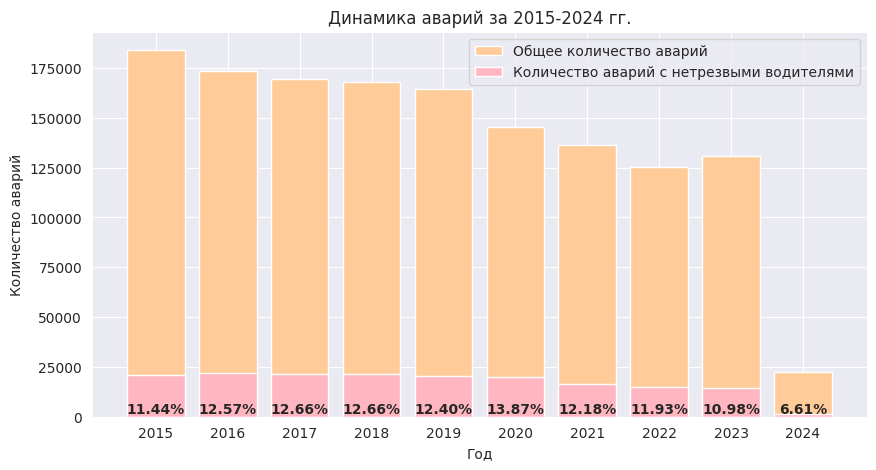

In [75]:
year_plot = merged_data[['id','datetime']].copy()
year_plot['drunk_driver'] = year_plot['id'].isin(df_people[df_people['violations'].str.contains('опьянен|алког', case=False, na=False)].\
  query('role=="Водитель"')['id'])
year_plot['year'] = year_plot['datetime'].dt.year


total_accidents = year_plot['year'].value_counts().sort_index()


drunk_driver_accidents = year_plot[year_plot['drunk_driver'] == True]['year'].value_counts().sort_index()


percentage_drunk_driver_accidents = ((drunk_driver_accidents / total_accidents) * 100).reset_index().rename(columns={'count': 'procent'})

plt.figure(figsize=(10, 5))
plt.bar(total_accidents.index, total_accidents.values, label='Общее количество аварий', color='#ffcc99')
plt.bar(drunk_driver_accidents.index, drunk_driver_accidents.values, label='Количество аварий с нетрезвыми водителями', color='#ffb6c1')

for i in range(len(percentage_drunk_driver_accidents)):
    plt.text(percentage_drunk_driver_accidents['year'][i], percentage_drunk_driver_accidents['procent'][i], f"{percentage_drunk_driver_accidents['procent'][i]:.2f}%", ha='center', va='bottom',fontweight='bold')

plt.title('Динамика аварий за 2015-2024 гг.')

plt.xlabel('Год')
plt.ylabel('Количество аварий')
plt.legend()
plt.xticks(total_accidents.index)
plt.show()

**На графике видно, снижение количества ДТП с участием нетрезвых водителей именно с 2021 года. Так уже в 2023 году количество аварий не превысило 15 тыс. и составляет 10.66% от всех аварий. Похоже, что ужесточение законов влияет на количество нетрезвых водителей, проверим данное предположение статистическим тестом.**


Сформируем группы до и после закона

In [76]:
year_plot = merged_data[['id','datetime']].copy()
year_plot['drunk_driver'] = year_plot['id'].isin(df_people[df_people['violations'].str.contains('опьянен|алког', case=False, na=False)].\
  query('role=="Водитель"')['id'])
year_plot['law'] = year_plot['datetime'] >= '2021-07-01'


In [77]:
year_plot[['drunk_driver','law']].corr(method= 'spearman')

,drunk_driver,law
drunk_driver,1.000000,-0.015216
law,-0.015216,1.000000


**Имеется очень слабая отрицательная корреляция между водителями в состоянии опьянения и принятием закона.**

Просмотрим общие данные до введения закона и после.

In [78]:
print(f'    Всего ДТП - {len(year_plot)}\n\
    ДТП с участием нетрезвых водителей всего - {len(year_plot.query("drunk_driver==True"))}\n\
    ДТП с участием трезвых водителей всего   - {len(year_plot.query("drunk_driver==False"))}\n\
    Процент ДТП с участием нетрезвых водителей до принятия закона    - {len(year_plot.query("law==False and drunk_driver==True"))/len(year_plot.query("law==False")):.2%}\n\
    Процент ДТП с участием нетрезвых водителей после принятия закона    - {len(year_plot.query("law==True and drunk_driver==True"))/len(year_plot.query("law==True")):.2%}')

    Всего ДТП - 1419979
    ДТП с участием нетрезвых водителей всего - 173579
    ДТП с участием трезвых водителей всего   - 1246400
    Процент ДТП с участием нетрезвых водителей до принятия закона    - 12.51%
    Процент ДТП с участием нетрезвых водителей после принятия закона    - 11.36%


Сформулируем гипотезы для проведения статистического теста.

Н0 = Доля ДТП с участием нетрезвых водителей до ужесточения закона = Доли ДТП с участием нетрезвых водителей после введения закона

Н1 = Доля ДТП с участием нетрезвых водителей до ужесточения закона < Доли ДТП с участием нетрезвых водителей после введения закона

In [79]:
drink = np.array([len(year_plot.query("law==False and drunk_driver==True")), len(year_plot.query("law==True and drunk_driver==True"))])
law = np.array([len(year_plot.query("law==False")),len(year_plot.query("law==True"))])

In [80]:

# Выполнение z-теста
def z_test(sample,all,alpha,alternative):
  ztest, p_value = sp.proportions_ztest(sample, all,alternative=alternative)
  print(f"Z-статистика: {ztest:.2f}")
  print(f"P-значение: {p_value:.2f}")
  if p_value < alpha:
        print('Отвергаем нулевую гипотезу: есть значимая разница')
  else:
        print(
            'Не получилось отвергнуть нулевую гипотезу'
        )

In [81]:
z_test(drink,law,.05,'larger')

Z-статистика: 18.13
P-значение: 0.00
Отвергаем нулевую гипотезу: есть значимая разница


Вывод:
1.   Один из наиболее строгих законов введен в 2019 году, но после его введения количество ДТП с участием нетрезвых водителей только увеличилось.
2.   После закона принятого в 2021 заметно снижения количества аварий с участием нетрезвых водителей, возможно после этого также участились проверки на дорогах, что предотвращает ДТП.
3.   Имеется слабая отрицательная корреляция между состоянием водителями и датой принятия закона.
4.   Z-test показывает, что мы отвергаем нулевую гипотезу, о равенстве долей ДТП с участием нетрезвых водителей до и после закона. Но корреляция показывает слабую взаимосвязь, возможно, другие аспекты повлияли на снижение количества ДТП с нетрезвыми водителями.




### Всему виной пьяные водители, надо усилить наказание

**Как было установлено ранее, всего ~12.66% аварий участвуют нетрезвые водители, при этом их участие в авариях в последнее время снижается.**

Проверим как влияет состояние водителя на тяжесть ДТП.

In [82]:
year_plot = merged_data[['id','dead_count','injured_count','severity']].copy()
year_plot['drunk_driver'] = year_plot['id'].isin(df_people[df_people['violations'].str.contains('опьянен|алког', case=False, na=False)].\
  query('role=="Водитель"')['id'])

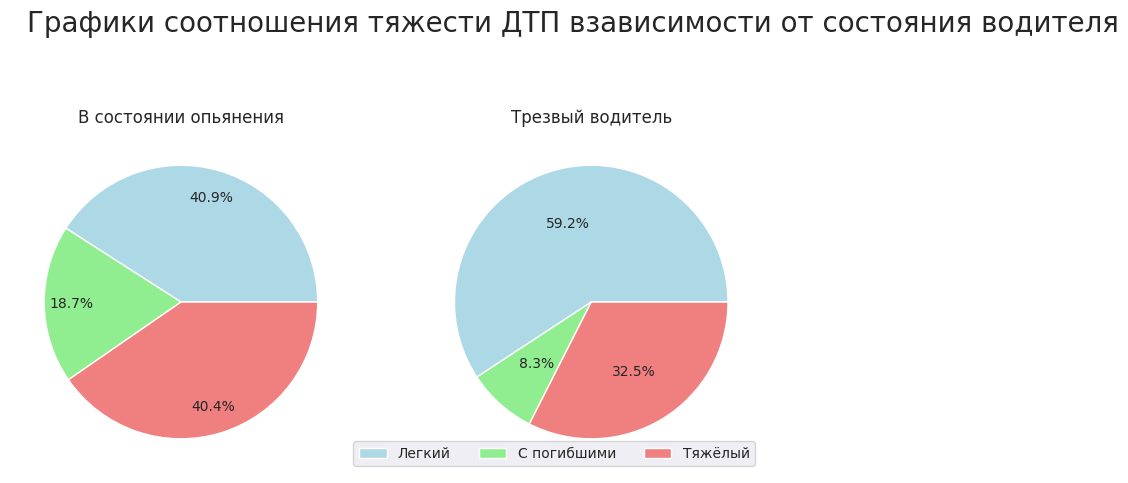

In [83]:
severity_light = year_plot.groupby(['severity','drunk_driver'])['id'].count().reset_index()
labels = severity_light.severity.unique().to_list()
colors=['#add8e6', '#90ee90', '#f08080', '#ffcc99', '#ffb6c1']
plt.figure(figsize=(15, 15))
plt.suptitle('Графики соотношения тяжести ДТП взависимости от состояния водителя',fontsize = 20,y=0.9)
plt.subplot(2, 3, 1)
plt.pie(severity_light.loc[(severity_light['drunk_driver'] == True), ['id']]['id'],colors=colors,pctdistance=0.8, autopct='%.1f%%')
plt.title("В состоянии опьянения")
# График 2
plt.subplot(2, 3, 2)
plt.pie(severity_light.loc[(severity_light['drunk_driver'] == False), ['id']]['id'],colors=colors, autopct='%.1f%%')
plt.title("Трезвый водитель")

plt.legend(labels, loc='lower right',ncol=3)
plt.show()

**На графиках видно, что нетрезвый водитель на дороге опаснее. Более чем на 10% увеличилось количество ДТП с летальным исходом и на 7.9% с тяжёлыми травмами.**

In [84]:
print('Статистика по ДТП с участием трезвых водителей')
display(year_plot.query('drunk_driver==False')[['dead_count','injured_count']].describe().round(3))
print()
print('Статистика по ДТП с участием нетрезвых водителей')
display(year_plot.query('drunk_driver==True')[['dead_count','injured_count']].describe().round(3))

Статистика по ДТП с участием трезвых водителей


,dead_count,injured_count
count,1246400.000,1246400.000
mean,0.097,1.254
std,0.360,0.882
min,0.000,0.000
25%,0.000,1.000
50%,0.000,1.000
75%,0.000,1.000
max,20.000,57.000



Статистика по ДТП с участием нетрезвых водителей


,dead_count,injured_count
count,173579.000,173579.000
mean,0.226,1.348
std,0.532,1.002
min,0.000,0.000
25%,0.000,1.000
50%,0.000,1.000
75%,0.000,2.000
max,9.000,42.000


**Если в среднем на одну аварию с трезвым водителем приходится 0.097 жертв с летальным исходом, то у водителя в состоянии опьянения этот показатель составляет 0.225.**
**В отношении пострадавших на одну аварию трезвого водителя приходится 1.255 пострадавших, у нетрезвого 1.348.**

**В самых крупных авариях по числу жертв участвовали трезвые водители за частую за рулем автобусов.**

In [85]:
year_plot[['drunk_driver','dead_count','injured_count']].corr(method= 'spearman')

,drunk_driver,dead_count,injured_count
drunk_driver,1.000000,0.116621,0.037478
dead_count,0.116621,1.000000,-0.337101
injured_count,0.037478,-0.337101,1.000000


По корреляции Спирмена, имеется слабая взаимосвязь между состоянием водителя и количеством умерших/пострадавших.

Сформулируем гипотезы для проведения статистического теста.

Н0 = Доля ДТП с участием нетрезвых водителей и с летальным/тяжелым исходом = Доля ДТП с участием трезвых водителей и с летальным/тяжелым исходом

Н1 = Доля ДТП с участием нетрезвых водителей и с летальным/тяжелым исходом > Доля ДТП с участием трезвых водителей и с летальным/тяжелым исходом

In [86]:
def t_test(columnA,columnB,alpha):
  p_value = st.ttest_ind(columnA,
                        columnB,
                        equal_var=False,
                        alternative='greater')[1]

  print('p-значение: ', p_value)
  if p_value > alpha:
      print('Не удалось отвергнуть нулевую гипотезу')

  print('Нулевая гипотеза отвергнута')

In [87]:
t_test(year_plot.query("drunk_driver==True")['dead_count'],year_plot.query("drunk_driver==False")['dead_count'],.05)

p-значение:  0.0
Нулевая гипотеза отвергнута


In [88]:
t_test(year_plot.query("drunk_driver==True")['injured_count'],year_plot.query("drunk_driver==False")['injured_count'],.05)

p-значение:  2.036699622693382e-295
Нулевая гипотеза отвергнута


Вывод:


1.   По данным графикам у нетрезвых водителей % аварий с тяжело раненными и погибшими больше, чем у трезвого водителя.
2.   Между состоянием водителя и количеством пострадавших/умерших имеется слабая корреляция.
3.   Нулевая гипотеза отвергается, Доля ДТП с участием нетрезвых водителей и с летальным/тяжелым исходом > Доля ДТП с участием трезвых водителей и с летальным/тяжелым. Но из-за низкой корреляции, сложно сказать повлияло непосредственно опьянение на такой исход. Возможно, нетрезвые водители чаще ездят ночью, когда видимость хуже.



### Влияние скорости на тяжесть ДТП

Создадим выборку по условию "Несоответствие скорости конкретным условиям движения" или "Превышение установленной скорости движения".

Несоответствие скорости конкретным условиям движения данное нарушение подразумевает, что водитель должен вести транспортное средство со скоростью, учитывающей интенсивность движения, особенности и состояние транспортного средства и груза, дорожные и метеорологические условия.



In [89]:
year_plot = merged_data[['id','dead_count','injured_count','severity','datetime']].copy()
year_plot['excess'] = year_plot['id'].isin(df_people[df_people['violations']\
  .str.contains('Несоответствие скорости конкретным условиям движения|Превышение установленной скорости движения', case=False, na=False)].\
  query('role=="Водитель"')['id'])

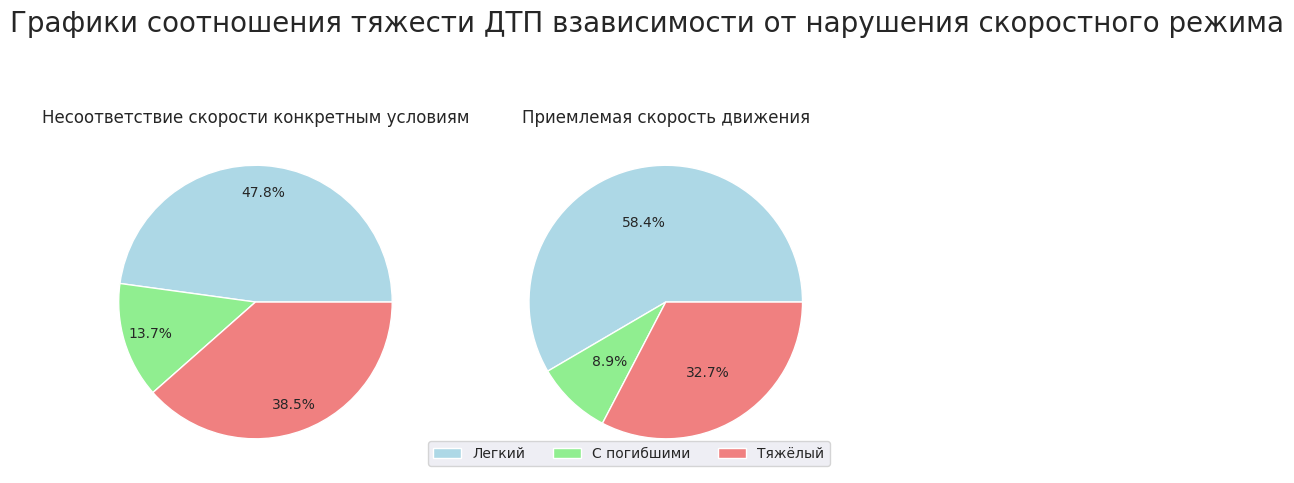

In [90]:
severity_light = year_plot.groupby(['severity','excess'])['id'].count().reset_index()
labels = severity_light.severity.unique().to_list()
colors=['#add8e6', '#90ee90', '#f08080', '#ffcc99', '#ffb6c1']
plt.figure(figsize=(15, 15))
plt.suptitle('Графики соотношения тяжести ДТП взависимости от нарушения скоростного режима',fontsize = 20,y=0.9)
plt.subplot(2, 3, 1)
plt.pie(severity_light.loc[(severity_light['excess'] == True), ['id']]['id'],colors=colors,pctdistance=0.8, autopct='%.1f%%')
plt.title("Несоответствие скорости конкретным условиям")
# График 2
plt.subplot(2, 3, 2)
plt.pie(severity_light.loc[(severity_light['excess'] == False), ['id']]['id'],colors=colors, autopct='%.1f%%')
plt.title("Приемлемая скорость движения")

plt.legend(labels, loc='lower right',ncol=3)
plt.show()

**У водителей соблюдающих скоростной режим смертность и получение тяжелых травм для участников ДТП ниже. Более 58% ДТП в таких случаях обходятся легкими повреждениями.**

In [91]:
year_plot[['excess','dead_count','injured_count']].corr(method= 'spearman')

,excess,dead_count,injured_count
excess,1.000000,0.055587,0.023629
dead_count,0.055587,1.000000,-0.337101
injured_count,0.023629,-0.337101,1.000000


Корреляция между скоростью, количеством погибших и количеством травмированых низкая.

Проведем статистические тесты. Для этого сформулируем гипотезы:

Н0 = Доля ДТП с нарушением скоростного режима и с летальным/тяжелым исходом = Доли ДТП с без нарушений скоростного режима и с летальным/тяжелым исходом

Н1 = Доля ДТП с нарушением скоростного режима и с летальным/тяжелым исходом > Доли ДТП с без нарушений скоростного режима и с летальным/тяжелым исходом

In [92]:
t_test(year_plot.query("excess==True")['dead_count'],year_plot.query("excess==False")['dead_count'],.05)

p-значение:  0.0
Нулевая гипотеза отвергнута


In [93]:
t_test(year_plot.query("excess==True")['injured_count'],year_plot.query("excess==False")['injured_count'],.05)

p-значение:  1.2203462901073864e-134
Нулевая гипотеза отвергнута


Вывод:


1.   Более 58% ДТП без нарушения скоростного режима обходятся легкими повреждениями участников ДТП.
2.   Нулевые гипотезы отвергнуты, доля ДТП где превышался скоростной режим влечет за собой возможность, получить летальный исход или тяжелые травмы. Однако, корреляция низкая и нельзя с уверенностью сказать, что именно скорость влияет на тяжесть ДТП.
3.   Во многих европейских городах уже началось снижение допустимой скорости до 30 км/ч и это имеет позитивный эффект, помимо снижения травматизации данная мера позволяет снизить количество пробок, люди меньше попадают в аварии и не блокируют дороги.(https://iz.ru/1248000/galina-volynetc/tishe-edut-zachem-evropeiskie-goroda-ogranichivaiut-skorost-do-30-kmch)



### Только новички попадают в ДТП

Посчитаем количество аварий по стажу водителя и с заполненой ячейков в столбце нарушения, так мы исключим пострадавших водителей.

In [94]:
year_plot = df_people.query('role=="Водитель" and violations!="" and not years_of_driving_experience.isna()')\
  .years_of_driving_experience.value_counts().reset_index()

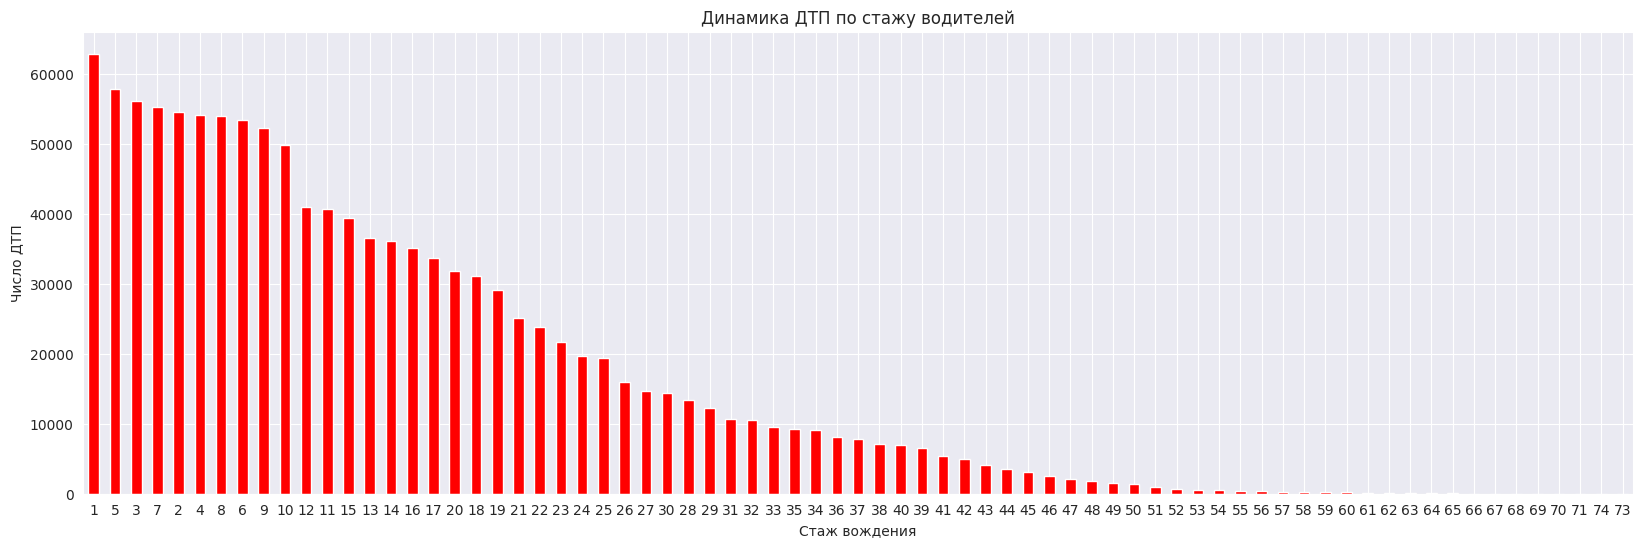

In [95]:
year_plot.plot(kind='bar',x='years_of_driving_experience', grid=True, figsize=[20, 6],color = 'red')
plt.title('Динамика ДТП по стажу водителей')
plt.xlabel('Стаж вождения')
plt.xticks(rotation=0)
plt.legend().remove()
plt.ylabel('Число ДТП');

**На графике мы видим скошенность в правую сторону. То есть чем больше у водителя стаж, тем меньше он становится виновником аварии. Особенно выделяются первые десять лет водительского стажа на них приходится более 45% ДТП.**

In [96]:
year_plot.corr(method='spearman')

,years_of_driving_experience,count
years_of_driving_experience,1.000000,-0.999044
count,-0.999044,1.000000


**Имеется сильная отрицательная взаимосвязь, что подтверждается графиком. Из чего можно сказать, что водители с большим стажем вождения реже попадают в ДТП**

**В качестве уменьшения количества ДТП, можно ввести за большой стаж вождения без аварий: скидки на парковку, выделить знаком "Опытный водитель" обратный знаку «Начинающий водитель», сниженный процент на покупку нового авто и т.д.**

### Если пешеходы не будут нарушать, то и не будут гибнуть

Построим график соотношения тяжести последствий ДТП в разрезе нарушал пешеход ПДД или нет.

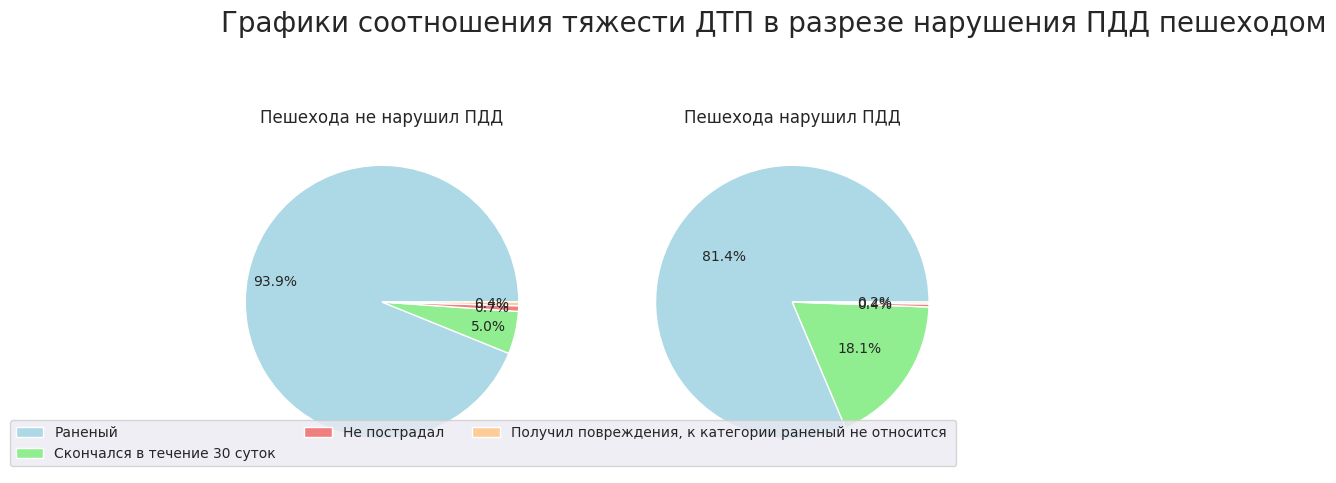

In [97]:
violations = df_people.query('role=="Пешеход"')
colors=['#add8e6', '#90ee90', '#f08080', '#ffcc99', '#ffb6c1']
labels = violations.health_status.unique().to_list()
plt.figure(figsize=(15, 15))
plt.suptitle('Графики соотношения тяжести ДТП в разрезе нарушения ПДД пешеходом',fontsize = 20,y=0.9)
plt.subplot(2, 3, 1)
plt.pie(violations.query('violations==""')['health_status'].value_counts(),colors=colors,pctdistance=0.8, autopct='%.1f%%')
plt.title("Пешехода не нарушил ПДД")
# График 2
plt.subplot(2, 3, 2)
plt.pie(violations.query('violations!=""')['health_status'].value_counts(),colors=colors, autopct='%.1f%%')
plt.title("Пешехода нарушил ПДД")

plt.legend(labels, loc='lower right',ncol=3)
plt.show()

**Из графика видно, что у пешеходов нарушавших ПДД смертность выше более чем на 13%.**

In [98]:
violations.loc[:, 'violations_t_f'] = np.where(violations['violations']=="", False, True )

<ipython-input-98-cb1b81fb0e8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violations.loc[:, 'violations_t_f'] = np.where(violations['violations']=="", False, True )


In [99]:
violations.loc[:, 'health_status'] = violations['health_status'].replace({'Раненый':2, 'Скончался в течение 30 суток':3, 'Не пострадал':0, 'Получил повреждения, к категории раненый не относится ':1})
violations.health_status = violations.health_status.astype('int')

<ipython-input-99-da6de002588b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violations.health_status = violations.health_status.astype('int')


In [100]:
violations[['health_status','violations_t_f']].corr(method= 'spearman')

,health_status,violations_t_f
health_status,1.000000,0.208509
violations_t_f,0.208509,1.000000


Присутствует слабая корреляция между наличием нарушений у пешехода и тяжестью травм.

Сформируем гипотезы для статистического теста:

Н0 = Доля ДТП со смертельным исходом среди пешеходов нарушивших ПДД  = Доля ДТП со смертельным исходом среди пешеходов не нарушивших ПДД

Н1 = Доля ДТП со смертельным исходом среди пешеходов нарушивших ПДД > Доля ДТП со смертельным исходом среди пешеходов не нарушивших ПДД

In [101]:
health_status = np.array([len(violations.query("violations_t_f==True and health_status==3")), len(violations.query("violations_t_f==False and health_status==3"))])
violations_t_f = np.array([len(violations.query("violations_t_f==True")),len(violations.query("violations_t_f==False"))])

In [102]:
z_test(health_status,violations_t_f,.05,'larger')

Z-статистика: 137.75
P-значение: 0.00
Отвергаем нулевую гипотезу: есть значимая разница


**Отвергаем нулевую гипотезу, есть значимая разница между долями ДТП со смертельным исходом среди пешеходов нарушивших и не нарушивших ПДД.**



### Ремни безопасности не спасают во время ДТП

In [103]:
year_plot = df_people.copy()
year_plot['no_belt'] = year_plot['violations']\
  .str.contains('(ставится в случае, когда не пристегнут водитель)|Нарушение правил применения ремней безопасности пассажиром',\
                case=False, na=False)

<ipython-input-103-a5523b406257>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  year_plot['no_belt'] = year_plot['violations']\


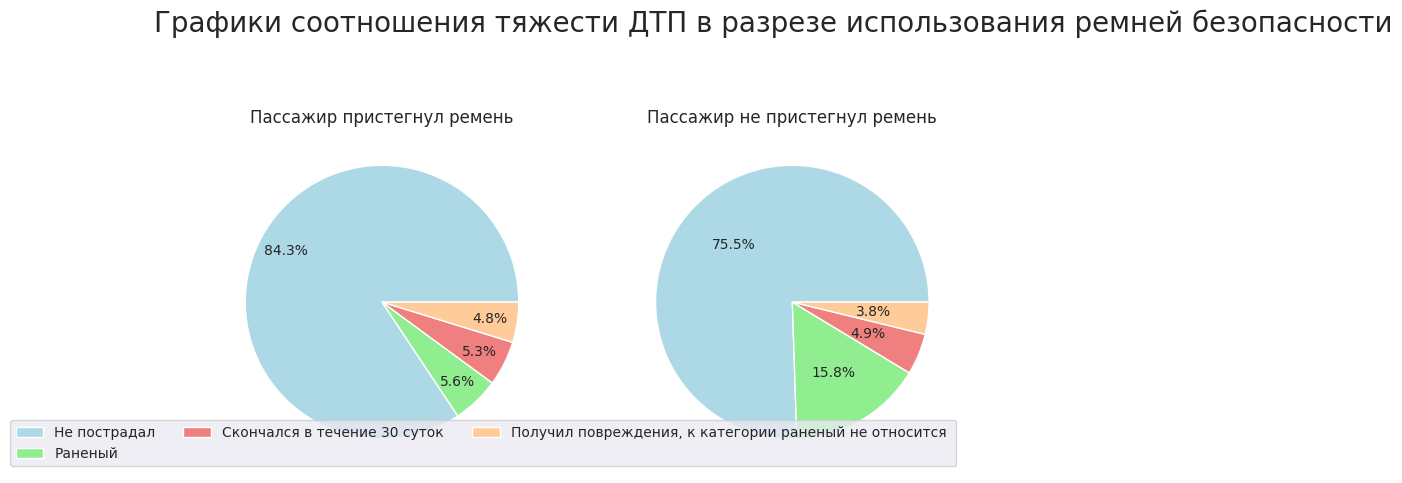

In [104]:
colors=['#add8e6', '#90ee90', '#f08080', '#ffcc99', '#ffb6c1']
labels = year_plot.health_status.unique().to_list()
plt.figure(figsize=(15, 15))
plt.suptitle('Графики соотношения тяжести ДТП в разрезе использования ремней безопасности',fontsize = 20,y=0.9)
plt.subplot(2, 3, 1)
plt.pie(year_plot.query('role=="Пассажир" and no_belt==False')['health_status'].value_counts(),colors=colors,pctdistance=0.8, autopct='%.1f%%')
plt.title("Пассажир пристегнул ремень")
# График 2
plt.subplot(2, 3, 2)
plt.pie(year_plot.query('role=="Пассажир" and no_belt==True')['health_status'].value_counts(),colors=colors, autopct='%.1f%%')
plt.title("Пассажир не пристегнул ремень")

plt.legend(labels, loc='lower right',ncol=3)
plt.show()

**Разница в смертности между пассажирами, которые пристегнули ремень или не стали это делать, почти нет. Это можно объяснить, тем что пассажир может сидеть на большом удалении от точки столкновения. К примеру, он может быть пассажиром автобуса и сидеть в салоне или занимать задние места в автомобили.**

**Но если пассажир не пристегивается, его шансы получить ранение увеличиваются.**

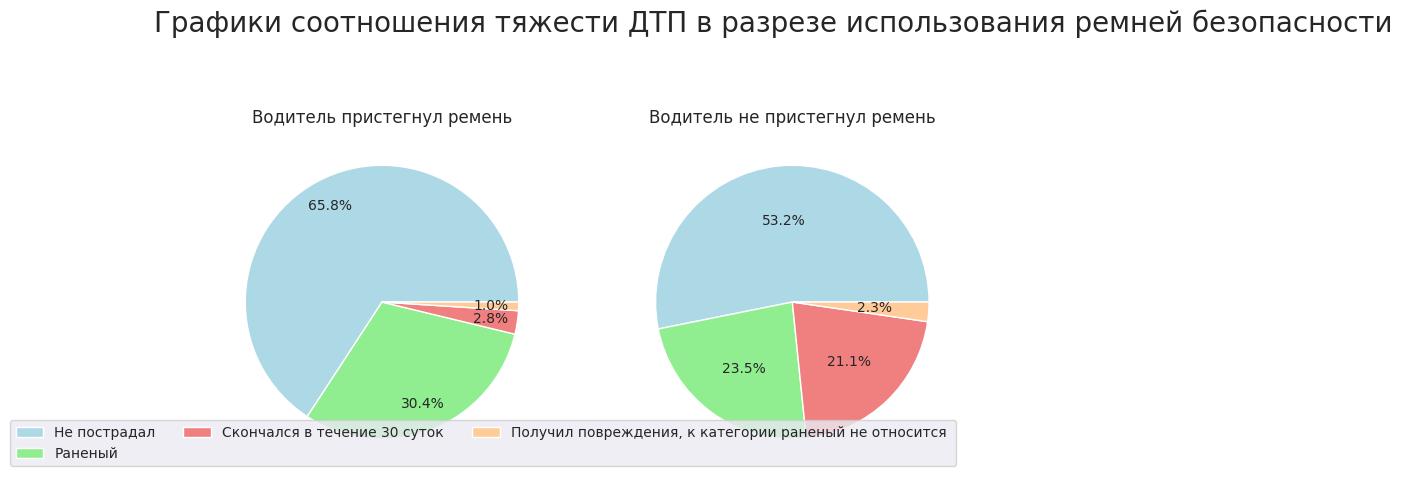

In [105]:
colors=['#add8e6', '#90ee90', '#f08080', '#ffcc99', '#ffb6c1']
labels = year_plot.health_status.unique().to_list()
plt.figure(figsize=(15, 15))
plt.suptitle('Графики соотношения тяжести ДТП в разрезе использования ремней безопасности',fontsize = 20,y=0.9)
plt.subplot(2, 3, 1)
plt.pie(year_plot.query('role=="Водитель" and no_belt==False')['health_status'].value_counts(),colors=colors,pctdistance=0.8, autopct='%.1f%%')
plt.title("Водитель пристегнул ремень")
# График 2
plt.subplot(2, 3, 2)
plt.pie(year_plot.query('role=="Водитель" and no_belt==True')['health_status'].value_counts(),colors=colors, autopct='%.1f%%')
plt.title("Водитель не пристегнул ремень")

plt.legend(labels, loc='lower right',ncol=3)
plt.show()

**Смертность у не пристегнутых водителей увеличивается в 7.5 раз.**

Сформируем гипотезы для статистического теста:

Н0 = Доля ДТП со смертельным исходом среди не пристегнутых водителей  = Доля ДТП со смертельным исходом среди пристегнутых водителей

Н1 = Доля ДТП со смертельным исходом среди не пристегнутых водителей  < Доля ДТП со смертельным исходом среди пристегнутых водителей

In [106]:
health_status = np.array([len(year_plot.query("no_belt==False and role=='Водитель' and health_status=='Скончался в течение 30 суток'")), len(year_plot.query("no_belt==True and role=='Водитель' and health_status=='Скончался в течение 30 суток'"))])
no_belt = np.array([len(year_plot.query("no_belt==False and role=='Водитель'")),len(year_plot.query("no_belt==True and role=='Водитель'"))])

In [107]:
z_test(health_status,no_belt,.05,'smaller')

Z-статистика: -206.30
P-значение: 0.00
Отвергаем нулевую гипотезу: есть значимая разница


**Отвергаем нулевую гипотезу, имеется значимая разница между долями ДТП со смертельным исходом между пристегнутыми и не пристегнутыми водителями. Стоит пересмотреть наказания за вождение без использования ремней безопасности, так как это влияет на летальность ДТП.**

## Вывод

При проведении исследовательского анализа выявлено следующие:

 * Заметна положительная динамика по уменьшению ДТП в РФ;
 * Пик ДТП приходиться на лето;
 * Наиболее опасными для пешеходов являются месяца, когда наступает межсезонье и похолодание. Возможно, не все водители вовремя успевают сменить резину, либо производится некачественная чистка дорог, что снижает сцепление с дорогой;
 * Количество ДТП с участием детей сильно возврастает с мая по август. В это время у школьников начинаются каникулы, они больше времени проводят на улице и чаще становятся участниками ДТП;
 * Более половины ДТП заканчиваются лёгкими ушибами;
 * Снижение освещенности увеличивается тяжесть ДТП. Можно предположить, что участники дорожного движения не успевают вовремя среагировать, осуществить манёвр или сбросить скорость;
 * Преобладают 2 категории ДТП:"Столкновение" и "Наезд на пешехода". На эти категории приходится 71.3% всех ДТП в России;
 * В пятёрку субъектов по количеству аварий входят: Москва, Краснодарский край, Санкт-Петербург, Московская область, Нижегородская область;
 * Пятерка лидеров по количеству аварий с погибшими отличается, от рейтинга субъектов по количеству аварий, в него входят: Московская область, Краснодарский край, Ростовская область, Республика Башкортостан, Москва;
 * В процентном соотношении смертность в ДТП по регионам выглядит совсем иначе, в лидерах кавказские регионы: Чеченская Республика, Республика Ингушетия, Республика Дагестан, Кабардино-Балкарская Республика и Республика Тыва. Смертность в ДТП у этих регионов находиться в промежутке 16%-29%. В то время как у Москвы и Санкт-Петербурга самые низкие показатели 4% и 3%;
 * В подавляющей большинстве в ДТП участвуют легковые автомобили. Следом с большим отставанием идут грузовые автомобили и автобусы и иной пассажирский транспорт;
 * Отдельно стоит отметить рост ДТП с участием велосипедов и электросамокатов. Он начал расти в ковидное время и не упал, это можно связать с развитием сервисов доставок на дом;
 * Самое часто встречающееся нарушение у водителей — это несоблюдение требований ОСАГО. На 7 и 8 месте популярности идут нарушения, которые серьёзно влияют на безопасность пешеходов — это Нарушение правил проезда пешеходного перехода и Управление ТС в состоянии алкогольного опьянения;
 * У пешеходов, самыми частыми нарушениями являются: переход дороги в неположенном месте и неожиданные выходы на дорогу из-за различных объектов.

 Было проверено 5 гипотез:



 1. Влияния ужесточения законов для нетрезвых водителей.

   1.1.   Один из наиболее строгих законов введён в 2019 году, но после его введения количество ДТП с участием нетрезвых водителей только увеличилось.

   1.2.   После закона, принятого в 2021 заметно снижения количества аварий с участием нетрезвых водителей, возможно, после этого также участились проверки на дорогах, что предотвращает ДТП.

   1.3.   Имеется слабая отрицательная корреляция между состоянием водителями и датой принятия закона.

   1.4.   Z-test показывает, что мы отвергаем нулевую гипотезу, о равенстве долей ДТП с участием нетрезвых водителей до и после закона. Но корреляция показывает слабую взаимосвязь, возможно, другие аспекты повлияли на снижение количества ДТП с нетрезвыми водителями.

 2. Всему виной пьяные водители, надо усилить наказание.

   2.1.   По данным графикам у нетрезвых водителей % аварий с тяжело раненными и погибшими больше, чем у трезвого водителя.

   2.2.   Между состоянием водителя и количеством пострадавших/умерших имеется слабая корреляция.

   2.3.   Нулевая гипотеза отвергается, доля ДТП с участием нетрезвых водителей и с летальным/тяжёлым исходом > Доля ДТП с участием трезвых водителей и с летальным/тяжёлым. Но из-за низкой корреляции, сложно сказать повлияло непосредственно опьянение на такой исход. Возможно, нетрезвые водители чаще ездят ночью, когда видимость хуже.

 3. Влияние скорости на тяжесть ДТП.

   3.1.   Более 58% ДТП у водителей, соблюдающих скоростной режим, обходятся лёгкими повреждениями участников ДТП, против 47% не соблюдавших его.

   3.2.   Нулевые гипотезы отвергнуты, доля ДТП, где превышался скоростной режим, влечёт за собой возможность, получить летальный исход или тяжёлые травмы. Однако корреляция низкая и нельзя с уверенностью сказать, что именно скорость влияет на тяжесть ДТП.

 4. Только новички попадают в ДТП.

    4.1. Водители с большим стажем вождения реже попадают в ДТП. Особенно это заметно после прохождения 10 летного стажа.

    4.2. Данный вывод подтверждает сильная отрицательная корреляция в 0.99.

 5. Ремни безопасности не спасают во время ДТП.

   5.1. Была проверена гипотеза  Доля ДТП со смертельным исходом среди непристёгнутых водителей < Доля ДТП со смертельным исходом среди пристёгнутых водителей.

   5.2. На графике сравнения видно, что смертность у непристёгнутых водителей увеличивается в 7.5 раз. При проведении статистического теста Н0 была отвергнута.
